<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_ImageAlignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: Image Alignment v1
Focused experiment into an alternative architecture for ImageAlignment.

This isn't actually the first such experiment. For earlier experiments see:
* `Experiment_SLAM_??.ipynb`  -- maybe v6?
* This notebook is also forked from the neuron-death/gradient-collapse notebook in the `training-instrumentation-toolkit`.

In this model, we start with an extreme alternative to downscaled-ConvNets -- a non-downscaled Conv + transformer.


In [1]:
# Install Training Instrumentation Toolkit
# (locked to specific git revision so this notebook always works)
import os
import sys
if not os.path.isdir('training-instrumentation-toolkit'):
  !git clone https://github.com/malcolmlett/training-instrumentation-toolkit.git
  !cd training-instrumentation-toolkit && git checkout 2d806af
sys.path.append('training-instrumentation-toolkit')

# Imports
import train_instrumentation as tinstr
import train_explainer as texpl
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from importlib import reload

Cloning into 'training-instrumentation-toolkit'...
remote: Enumerating objects: 1354, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 1354 (delta 62), reused 44 (delta 20), pack-reused 1239 (from 1)
Receiving objects: 100% (1354/1354), 97.11 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (811/811), done.
Note: switching to '2d806af'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2d806af Use full variable.path for plot label, works for multi

## Re-usable code

In [2]:
# In a later section I discovered that the default TF MHA block doesn't play well when the query and key inputs have different sequence lengths.
# When having it return the raw attention coefficients, it returned a square shape instead of one that reflected the the respective lengths of query and key.
# This custom layer implements a simple MHA so that I can be certain that it works.
# Also, it includes the option to skip the value output if all I want is the attention coefficients.
class CrossAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, value_dim, return_value=True, return_attention_scores=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.value_dim = value_dim
        self.return_value = return_value
        self.return_attention_scores = return_attention_scores
        self.sqrt_key_dim = tf.math.sqrt(tf.cast(self.key_dim, tf.float32))

        # Define trainable weight matrices for Q, K, V
        self.W_q = layers.Dense(num_heads * key_dim, use_bias=False, name="W_q")
        self.W_k = layers.Dense(num_heads * key_dim, use_bias=False, name="W_k")
        if return_value:
          self.W_v = layers.Dense(num_heads * value_dim, use_bias=False, name="W_v")
          self.W_out = layers.Dense(value_dim, use_bias=False, name="W_out")  # Final projection

    def call(self, query, key, value):
        """
        Args:
          query, key, value - Expecting (batch, seq_len, channels) for each,
            but seq_len for query/key can be different, and channels can
            be different.
        """

        batch_size = tf.shape(query)[0]
        q_len = tf.shape(query)[1]  # 256
        k_len = tf.shape(key)[1]    # 1024

        # Linear projections
        q = self.W_q(query)  # (batch, q_len, num_heads * key_dim)
        k = self.W_k(key)    # (batch, k_len, num_heads * key_dim)

        # Reshape for multi-heads: (batch, seq_len, num_heads, head_dim) -> (batch, num_heads, seq_len, head_dim)
        q = tf.reshape(q, [batch_size, q_len, self.num_heads, self.key_dim])
        k = tf.reshape(k, [batch_size, k_len, self.num_heads, self.key_dim])
        q = tf.transpose(q, [0, 2, 1, 3])  # (batch, num_heads, q_len, key_dim)
        k = tf.transpose(k, [0, 2, 1, 3])  # (batch, num_heads, k_len, key_dim)

        # Same as above for value, but only if outputting
        if self.return_value:
          v = self.W_v(value)  # (batch, k_len, num_heads * value_dim)
          v = tf.reshape(v, [batch_size, k_len, self.num_heads, self.value_dim])
          v = tf.transpose(v, [0, 2, 1, 3])  # (batch, num_heads, k_len, value_dim)

        # Compute scaled dot-product attention: Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
        attn_logits = tf.matmul(q, k, transpose_b=True)  # (batch, num_heads, q_len, k_len)
        attn_logits = attn_logits / self.sqrt_key_dim
        attn_weights = tf.nn.softmax(attn_logits, axis=-1)  # Normalize across keys (k_len=1024)

        # prepare value output
        if self.return_value:
          # Compute attention output
          attn_output = tf.matmul(attn_weights, v)  # (batch, num_heads, q_len, value_dim)

          # Transpose and reshape back to (batch, q_len, num_heads * value_dim)
          attn_output = tf.transpose(attn_output, [0, 2, 1, 3])  # (batch, q_len, num_heads, value_dim)
          attn_output = tf.reshape(attn_output, [batch_size, q_len, self.num_heads * self.value_dim])

          # Final projection back to value_dim
          attn_output = self.W_out(attn_output)  # (batch, q_len, value_dim)

        # return
        if self.return_value and self.return_attention_scores:
          return attn_output, attn_weights
        elif self.return_value:
          return attn_output
        else:
          return attn_weights

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "value_dim": self.value_dim,
            "return_value": self.return_value,
            "return_attention_scores": self.return_attention_scores
        })
        return config


layer = CrossAttention(num_heads=8, key_dim=16, value_dim=32, return_value=True, return_attention_scores=False)
x1 = tf.random.normal([32, 256, 16])
x2 = tf.random.normal([32, 1024, 16])
value = layer(query=x1, key=x2, value=x2)
print(f"value only:")
print(f"  value.shape: {value.shape}")
assert value.shape == (32, 256, 32)

layer = CrossAttention(num_heads=8, key_dim=16, value_dim=32, return_value=True, return_attention_scores=True)
x1 = tf.random.normal([32, 256, 16])
x2 = tf.random.normal([32, 1024, 16])
value, attn_weights = layer(query=x1, key=x2, value=x2)
print(f"value + attn_weights:")
print(f"  value.shape: {value.shape}")
print(f"  attn_weights.shape: {attn_weights.shape}")
assert value.shape == (32, 256, 32)
assert attn_weights.shape == (32, 8, 256, 1024)

layer = CrossAttention(num_heads=8, key_dim=16, value_dim=32, return_value=False, return_attention_scores=True)
x1 = tf.random.normal([32, 256, 16])
x2 = tf.random.normal([32, 1024, 16])
attn_weights = layer(query=x1, key=x2, value=x2)
print(f"attn_weights only:")
print(f"  attn_weights.shape: {attn_weights.shape}")
assert attn_weights.shape == (32, 8, 256, 1024)


value only:
  value.shape: (32, 256, 32)
value + attn_weights:
  value.shape: (32, 256, 32)
  attn_weights.shape: (32, 8, 256, 1024)
attn_weights only:
  attn_weights.shape: (32, 8, 256, 1024)


In [3]:
# CoordConv layer
# Based on R. Liu et al., “An Intriguing Failing of CNNs and the CoordConv Solution,” NeurIPS 2018
# https://arxiv.org/abs/1807.03247
class CoordConv(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        # inputs.shape => [batch_size, height, width, channels]
        batch_size, height, width, channels = tf.unstack(tf.shape(inputs))

        # Generate a coordinate grid:
        # - x_coords: shape (width,) from -0.5 to 0.5
        # - y_coords: shape (height,) from -0.5 to 0.5
        x_coords = tf.linspace(-0.5, 0.5, width)
        y_coords = tf.linspace(-0.5, 0.5, height)

        # Use meshgrid to get 2D coordinate maps
        # - xx, yy shape => (height, width)
        xx, yy = tf.meshgrid(x_coords, y_coords)

        # Reshape for appending as channels
        xx = tf.expand_dims(xx, axis=-1)  # (height, width, 1)
        yy = tf.expand_dims(yy, axis=-1)  # (height, width, 1)

        # Tile across batch dimension
        xx_tiled = tf.tile(tf.expand_dims(xx, 0), [batch_size, 1, 1, 1])
        yy_tiled = tf.tile(tf.expand_dims(yy, 0), [batch_size, 1, 1, 1])

        # Concatenate to inputs along the channel dimension
        # outputs.shape => [batch_size, height, width, channels+2]
        output = tf.concat([inputs, xx_tiled, yy_tiled], axis=-1)
        return output

input = tf.keras.Input(shape=(32, 32, 3))
cc = CoordConv()(input)
cc.shape

(None, 32, 32, 5)

## Dataset Pipeline


In [4]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Corners of crop image (raw):
    [ 0.04074597 -0.33624923]                -         [ 0.45840526 -0.12344116]
    [-0.1720621   0.08141005]                -         [0.24559724 0.29421812]
Corners of crop image (pixels):
    [17.303871   5.2400246]                -         [30.668968 12.049883]
    [10.494013 18.605122]                -         [23.859112 25.41498 ]


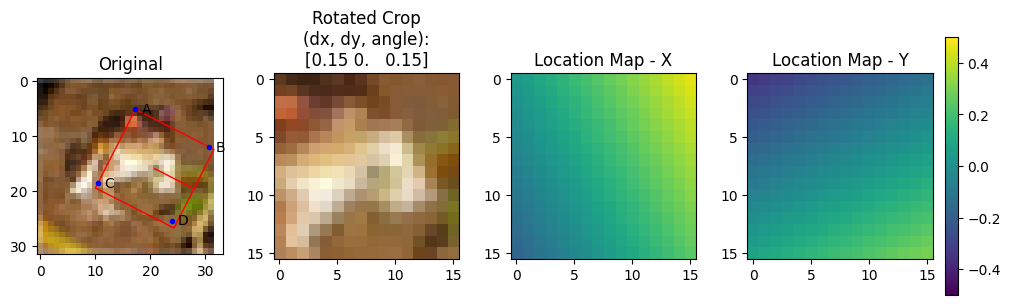

In [5]:
# image manipulation function
def rotated_crop(image, dx, dy, da, return_h_matrix=False):
    """
    Takes a 50% crop of the source image after applying a positional and angular
    offset relative to the image's centre.
    For example, (dx,dy,da) = (-0.25,0,0.5) will take a crop centred one quarter
    of the image width to the left from the source image centre and rotated
    45 degrees (50% of 180 in whichever direction the positive direction happens
    to take).
    Args:
      image: source image
      dx: float in range -0.5 .. +0.5 (fraction of width)
      dy: float in range -0.5 .. +0.5 (fraction of height)
      da: float in range -1.0 .. +1.0 (fraction of radians)
      return_location_map: bool. Whether to additionally return the homography matrix
    Returns:
      cropped_image
      OR
      cropped_image, homography_matrix (3x3)
    """
    # Image dimensions
    img_height, img_width = image.shape[0], image.shape[1]
    img_centre_x = img_width // 2
    img_centre_y = img_height // 2
    crop_size = img_height // 2  # 50% of original size (16x16 for CIFAR-10)
    crop_centre_x = crop_size // 2
    crop_centre_y = crop_size // 2

    # Step 1: Rotate crop window about its top-left corner
    # - assuming crop-mid is at (x,y)=(8,8)
    # - net result is that the crop-mid will move to crop_mid' = tf.linalg.matvec(R, crop_mid)
    R = tf.stack([
        [tf.cos(da * np.pi), -tf.sin(da * np.pi), 0],
        [tf.sin(da * np.pi), tf.cos(da * np.pi), 0],
        [0.0, 0.0, 1.0]
    ])
    R_neg = tf.stack([
        [tf.cos(-da * np.pi), -tf.sin(-da * np.pi), 0],
        [tf.sin(-da * np.pi), tf.cos(-da * np.pi), 0],
        [0.0, 0.0, 1.0]
    ])

    # Step 2a: Calculate crop-mid after rotation
    crop_mid = [crop_centre_x, crop_centre_y, 1.]
    crop_mid = tf.linalg.matvec(R, crop_mid)

    # Step 2b: Translate rotated location of crop-mid back to it's original position
    Tv = [crop_centre_x - crop_mid[0], crop_centre_y - crop_mid[1], 1.]

    # Step 2c: translate crop-mid to target location on source image
    tx = img_centre_x + dx * img_width - crop_centre_x
    ty = img_centre_y + dy * img_height - crop_centre_y
    Tv = [Tv[0] + tx, Tv[1] + ty, 1.]

    # Step 2d: reverse rotation impact before applying
    # - we'll apply the translation first, so it's ultimate effect is then rotated,
    #   so we counteract that effect by pre-rotating in the opposite direction
    Tv = tf.linalg.matvec(R_neg, Tv)
    T = tf.stack([
        [1.0, 0.0, Tv[0]],
        [0.0, 1.0, Tv[1]],
        [0.0, 0.0, 1.0]
    ])

    # combine transformations: R * T
    # - technically this is applying T first, and then R
    # - has effect of rotating crop window by R, and then translating by R(T)
    h_matrix = tf.linalg.matmul(R, T)

    # Flatten to 8 parameters (last is 1)
    transform = tf.reshape(h_matrix, [-1])[:-1]

    # Apply projective transform
    rotated_crop = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),  # Add batch dimension
        transforms=tf.expand_dims(transform, 0),  # Add batch dimension
        output_shape=[crop_size, crop_size],
        interpolation='BILINEAR',
        fill_value=0.0,
        fill_mode='CONSTANT'
    )[0]  # Remove batch dimension

    if return_h_matrix:
      return rotated_crop, h_matrix
    else:
      return rotated_crop

def compute_location_map(h_matrix, img_shape, crop_shape):
  """
  For each pixel (y, x) in the cropped image of shape (crop_height, crop_width, channels),
  computes where that pixel came from in the original image in normalized
  coordinates, i.e. (-0.5..+0.5, -0.5..+0.5).
  Args:
    h_matrix: 3x3 homography matrix
  Returns:
    location_map, shape (crop_height, crop_width, 2) of float, containing per-pixel locations
      from original image in range -0.5 .. +0.5 relative to original image centre.
  """
  img_width, img_height = img_shape[1], img_shape[0]
  crop_width, crop_height = crop_shape[1], crop_shape[0]

  # Build a meshgrid of output coords: shape (crop_size, crop_size)
  # indexing='ij' => Y first, then X
  y_coords = tf.range(crop_width, dtype=tf.float32)
  x_coords = tf.range(crop_height, dtype=tf.float32)
  Y, X = tf.meshgrid(y_coords, x_coords, indexing='ij')  # (crop_height, crop_width)

  # Stack and flatten => shape (crop_size*crop_size, 3)
  # - note: the transform requires coordinates in form (y, x, 1).
  ones = tf.ones_like(X)
  out_coords = tf.stack([Y, X, ones], axis=-1)
  out_coords_flat = tf.reshape(out_coords, [-1, 3])

  # Multiply: output -> input
  in_coords_flat = tf.linalg.matmul(out_coords_flat, h_matrix, transpose_b=True)

  # For safety in case of perspective transforms, divide by W
  in_coords_flat /= in_coords_flat[:, 2:3]

  # The returned in_coords_flat are [y, x, 1]. Slicing:
  in_y = in_coords_flat[:, 0]
  in_x = in_coords_flat[:, 1]

  # Normalize each axis to range [-0.5..+0.5]
  # center = W/2 or H/2, so x_norm = (X - W/2)/W
  x_norm = in_x / tf.cast(img_width, tf.float32)  - 0.5
  y_norm = in_y / tf.cast(img_height, tf.float32) - 0.5

  # Reshape back to (crop_height, crop_width, 2)
  pixel_map = tf.stack([x_norm, y_norm], axis=-1)
  pixel_map = tf.reshape(pixel_map, [crop_height, crop_width, 2])
  return pixel_map

def compute_location_map_xy(h_matrix, img_shape, crop_shape):
  """
  For each pixel (y, x) in the cropped image of shape (crop_height, crop_width, channels),
  computes where that pixel came from in the original image in normalized
  coordinates, i.e. (-0.5..+0.5, -0.5..+0.5).
  Args:
    h_matrix: 3x3 homography matrix
  Returns:
    location_map, shape (crop_height, crop_width, 2) of float, containing per-pixel locations
      from original image in range -0.5 .. +0.5 relative to original image centre.
  """
  img_width, img_height = img_shape[1], img_shape[0]
  crop_width, crop_height = crop_shape[1], crop_shape[0]

  # Build a meshgrid of output coords: shape (crop_size, crop_size)
  # indexing='ij' => Y first, then X
  y_coords = tf.range(crop_width, dtype=tf.float32)
  x_coords = tf.range(crop_height, dtype=tf.float32)
  Y, X = tf.meshgrid(y_coords, x_coords, indexing='ij')  # (crop_height, crop_width)

  # Stack and flatten => shape (crop_size*crop_size, 3)
  # - note: the transform requires coordinates in form (x, y, 1).
  ones = tf.ones_like(X)
  out_coords = tf.stack([X, Y, ones], axis=-1)
  out_coords_flat = tf.reshape(out_coords, [-1, 3])

  # Apply homography transform
  in_coords_flat = tf.linalg.matmul(out_coords_flat, h_matrix, transpose_b=True)
  in_coords_flat /= in_coords_flat[:, 2:3]  # safety: works for perspective changes too

  # The returned in_coords_flat are [x, y, 1]. Slicing:
  in_x = in_coords_flat[:, 0]
  in_y = in_coords_flat[:, 1]

  # Normalize each axis to range [-0.5..+0.5]
  # center = W/2 or H/2, so x_norm = (X - W/2)/W
  x_norm = in_x / tf.cast(img_width, tf.float32)  - 0.5
  y_norm = in_y / tf.cast(img_height, tf.float32) - 0.5

  # Reshape back to (crop_height, crop_width, 2)
  pixel_map = tf.stack([x_norm, y_norm], axis=-1)
  pixel_map = tf.reshape(pixel_map, [crop_height, crop_width, 2])
  return pixel_map

def draw_crop_template(image, transform):
  dx, dy, da = transform
  centre_x = image.shape[1] * (0.5 + dx)
  centre_y = image.shape[0] * (0.5 + dy)
  width = image.shape[1] // 2
  height = image.shape[0] // 2
  radians = da * np.pi

  # draw a rectangle showing the outline of where the crop was taken from
  ax = plt.gca()
  rect = patches.Rectangle((centre_x - width/2, centre_y - height/2), width, height, linewidth=1, edgecolor='r', facecolor='none')
  t = transforms.Affine2D().rotate_deg_around(centre_x, centre_y, radians * 180 / np.pi)
  rect.set_transform(t + ax.transData)
  ax.add_patch(rect)

  # draw a rotated 0-degrees line to indicate the rotation.
  line_end_x = centre_x + width / 2
  line_end_y = centre_y
  rotated_endpoint = t.transform([(line_end_x, line_end_y)])[0]
  ax.plot([centre_x, rotated_endpoint[0]], [centre_y, rotated_endpoint[1]], color='r', linewidth=1)

def decode_outputs(outputs):
  if isinstance(outputs, tuple):
    transform, location_map = outputs
  elif outputs.shape[-1] == 3:
    transform = outputs
    location_map = None
  else:
    transform = None
    location_map = outputs

  return transform, location_map

def show_data_sample(inputs, outputs):
  """
  Copes with usage any of:
  - show_data_sample((image, cropped), transform)
  - show_data_sample((image, cropped), location_map)
  - show_data_sample((image, cropped), (transform, location_map))
  """
  (image, cropped) = inputs
  transform, location_map = decode_outputs(outputs)

  plt.figure(figsize=(10, 3), layout='constrained')
  cols = 4 if location_map is not None else 2

  plt.subplot(1, cols, 1)
  plt.title("Original")
  plt.imshow(image)
  if transform is not None:
    draw_crop_template(image, transform)
  if location_map is not None:
    img_size_factor = np.array([image.shape[1], image.shape[0]])
    img_centre = np.array([image.shape[1] // 2, image.shape[0] // 2])
    a = location_map[0, 0, :] * img_size_factor + img_centre
    b = location_map[0, -1, :] * img_size_factor + img_centre
    c = location_map[-1, 0, :] * img_size_factor + img_centre
    d = location_map[-1, -1, :] * img_size_factor + img_centre
    points = np.array([a, b, c, d])
    plt.plot(points[:,0], points[:,1], 'b.')
    plt.text(a[0]+2, a[1], "A", horizontalalignment='center', verticalalignment='center')
    plt.text(b[0]+2, b[1], "B", horizontalalignment='center', verticalalignment='center')
    plt.text(c[0]+2, c[1], "C", horizontalalignment='center', verticalalignment='center')
    plt.text(d[0]+2, d[1], "D", horizontalalignment='center', verticalalignment='center')

    print(f"Corners of crop image (raw):")
    print(f"    {location_map[0, 0, :]}                -         {location_map[0, -1, :]}")
    print(f"    {location_map[-1, 0, :]}                -         {location_map[-1, -1, :]}")

    print(f"Corners of crop image (pixels):")
    print(f"    {a}                -         {b}")
    print(f"    {c}                -         {d}")

    # all points:
    #xs = location_map[..., 0] * img_size_factor[0] + img_centre[0]
    #ys = location_map[..., 1] * img_size_factor[1] + img_centre[1]
    #plt.plot(xs, ys, 'b.')

  plt.subplot(1, cols, 2)
  plt.title(f"Rotated Crop\n(dx, dy, angle):\n{transform}")
  plt.imshow(cropped)

  if location_map is not None:
    plt.subplot(1, cols, 3)
    plt.title(f"Location Map - X")
    plt.imshow(location_map[:,:,0], vmin=-0.5, vmax=+0.5)

    plt.subplot(1, cols, 4)
    plt.title(f"Location Map - Y")
    plt.imshow(location_map[:,:,1], vmin=-0.5, vmax=+0.5)
    plt.colorbar()

  plt.show()

image = x_train[0]
transform = tf.constant(([0.15, 0.0, 0.15]))
cropped, h_matrix = rotated_crop(image, dx=transform[0], dy=transform[1], da=transform[2], return_h_matrix=True)
location_map = compute_location_map_xy(h_matrix, image.shape, cropped.shape)
show_data_sample((image, cropped), (transform, location_map))

Original shape: (32, 32, 32, 3)
Rotated Crop shape: (32, 16, 16, 3)
Transformation shape: (32, 3)
Location Map shape: (32, 16, 16, 2)
Corners of crop image (raw):
    [-0.20351297 -0.16646901]                -         [ 0.20059872 -0.40399855]
    [0.03401655 0.2376427 ]                -         [4.3812829e-01 1.1318922e-04]
Corners of crop image (pixels):
    [ 9.487585 10.672992]                -         [22.419159   3.0720463]
    [17.08853  23.604567]                -         [30.020105 16.003622]


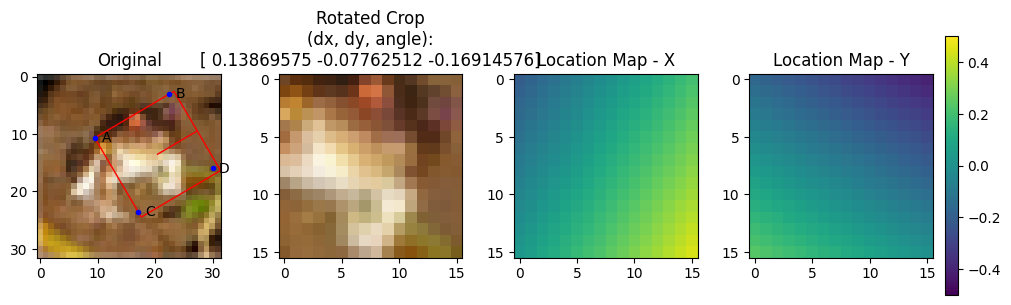

Time for 100 batches: 1.08 seconds
Total batches: 1563


In [6]:
# pre-processing pipeline
def _preprocess_image_configurable(image, return_transform: bool, return_location_map: bool):
    # Generate random translation and rotation
    # - dx/dy in range -0.5..+0.5 (fraction of width/height)
    # - da    in range -1.0..+1.0 (radians)
    # - small stddev
    dx = tf.clip_by_value(tf.random.normal([], mean=0, stddev=0.5/4), -0.5, 0.5)
    dy = tf.clip_by_value(tf.random.normal([], mean=0, stddev=0.5/4), -0.5, 0.5)
    da = tf.clip_by_value(tf.random.normal([], mean=0, stddev=1.0/4), -1.0, 1.0)

    # Take rotated crop
    cropped, h_matrix = rotated_crop(image, dx, dy, da, return_h_matrix=True)
    location_map = compute_location_map_xy(h_matrix, image.shape, cropped.shape)
    transform = tf.stack([dx, dy, da])

    # construct as input/output tuples
    if return_transform and return_location_map:
      return (image, cropped), (transform, location_map)
    elif return_transform:
      return (image, cropped), transform
    elif return_location_map:
      return (image, cropped), location_map
    else:
      raise ValueError(f"invalid output format: {return_transform=}, {return_location_map=}")

def preprocess_image_for_transform(image):
  return _preprocess_image_configurable(image, return_transform=True, return_location_map=False)

def preprocess_image_for_location_map(image):
  return _preprocess_image_configurable(image, return_transform=False, return_location_map=True)

def preprocess_image_for_both(image):
  return _preprocess_image_configurable(image, return_transform=True, return_location_map=True)

def prepared_dataset(output_format='transform'):
  if output_format == 'transform':
    preprocess_image = preprocess_image_for_transform
  elif output_format == 'location_map':
    preprocess_image = preprocess_image_for_location_map
  elif output_format == 'transform, location_map':
    preprocess_image = preprocess_image_for_both
  else:
    raise ValueError(f"invalid output format: {output_format}")

  train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
  train_dataset = train_dataset.map(
      preprocess_image,
      num_parallel_calls=tf.data.AUTOTUNE
  )
  return train_dataset

def take_sample(inputs, outputs, idx = 0):
  """Grabs the first sample from a batch"""
  if isinstance(inputs, tuple):
    input = tuple(sample[idx] for sample in inputs)
  elif isinstance(inputs, list):
    input = [sample[idx] for sample in inputs]
  else:
    inptu = inputs[idx]

  print(f"outputs: {type(outputs)}")
  if isinstance(outputs, tuple):
    output = tuple(sample[idx] for sample in outputs)
  elif isinstance(outputs, list):
    output = [sample[idx] for sample in outputs]
  else:
    output = outputs[idx]
  return input, output

def take_first_sample(inputs, outputs):
  return take_sample(inputs, outputs, 0)

# Create the dataset pipeline
train_dataset = prepared_dataset('transform, location_map').batch(32).prefetch(tf.data.AUTOTUNE)

# Test and visualize
def show_dataset(dataset):
  for inputs, outputs in dataset.take(1):
      (original, cropped) = inputs
      (transform, location_map) = decode_outputs(outputs)

      print("Original shape:", original.shape)         # [batch, 32, 32, 3]
      print("Rotated Crop shape:", cropped.shape)      # [batch, 16, 16, 3]
      if transform is not None:
        print("Transformation shape:", transform.shape)  # [batch, 3]
      if location_map is not None:
        print("Location Map shape:", location_map.shape)  # [batch, 16, 16, 2]

      input, output = take_first_sample(inputs, outputs)
      show_data_sample(input, output)
show_dataset(train_dataset)

# Optional: Time the pipeline
import time
start = time.time()
for _ in train_dataset.take(100):  # Process 100 batches
    pass
print(f"Time for 100 batches: {time.time() - start:.2f} seconds")
print(f"Total batches: {len(train_dataset)}")

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.23523372 -0.1427606 ]                -         [ 0.16341203 -0.38935363]
    [0.01135933 0.25588512]                -         [0.4100051  0.00929213]
Corners of crop image (pixels):
    [ 8.472521 11.431661]                -         [21.229185   3.5406837]
    [16.363499 24.188324]                -         [29.120163 16.297348]


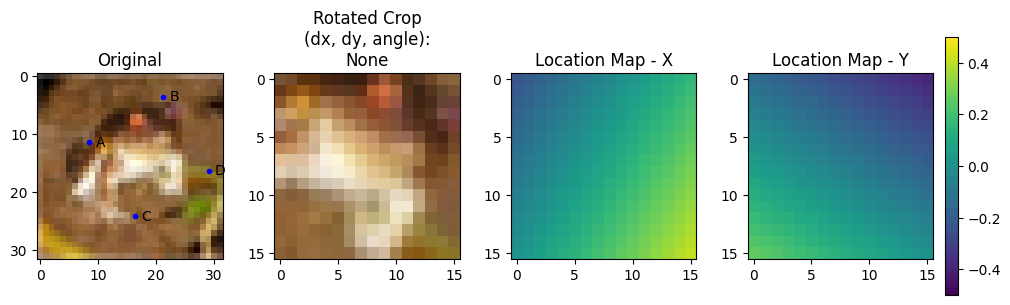

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [ 0.43240178 -0.31276384]                -         [0.40103066 0.15493524]
    [-0.0352973 -0.344135 ]                -         [-0.06666845  0.12356412]
Corners of crop image (pixels):
    [29.836857  5.991557]                -         [28.832981 20.957928]
    [14.870486   4.9876804]                -         [13.86661  19.954052]


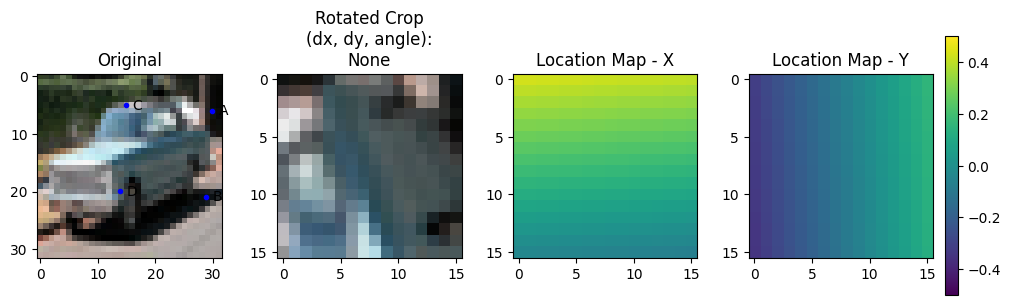

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.01693362 -0.16797578]                -         [0.30295217 0.17466056]
    [-0.35956994  0.15191007]                -         [-0.03968412  0.49454635]
Corners of crop image (pixels):
    [15.458124 10.624775]                -         [25.69447  21.589138]
    [ 4.493762 20.861122]                -         [14.730108 31.825483]


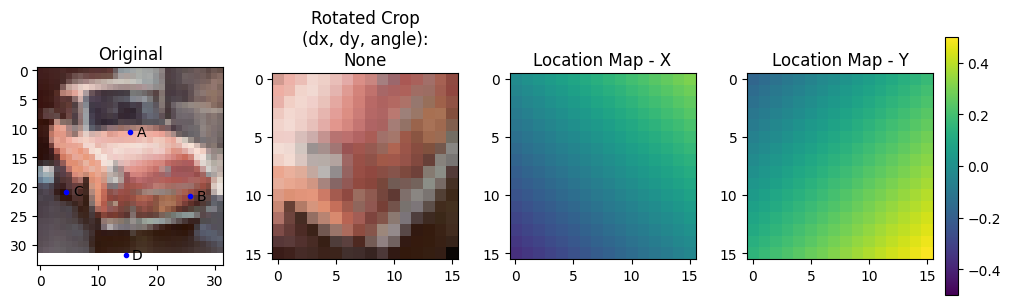

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [ 0.15301967 -0.03251079]                -         [0.02834457 0.41935498]
    [-0.2988461  -0.15718591]                -         [-0.42352122  0.29467988]
Corners of crop image (pixels):
    [20.89663  14.959655]                -         [16.907026 29.41936 ]
    [ 6.436925 10.970051]                -         [ 2.447321 25.429756]


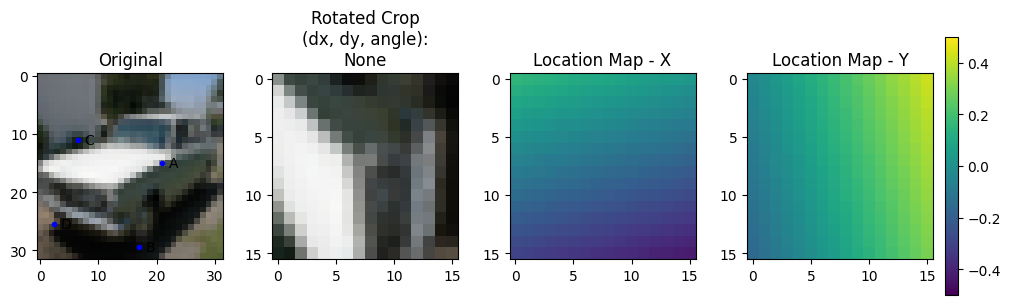

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.2660411  -0.14488167]                -         [ 0.16739696 -0.32336977]
    [-0.08755299  0.2885564 ]                -         [0.34588504 0.11006832]
Corners of crop image (pixels):
    [ 7.486685 11.363787]                -         [21.356703   5.6521673]
    [13.198304 25.233805]                -         [27.068321 19.522186]


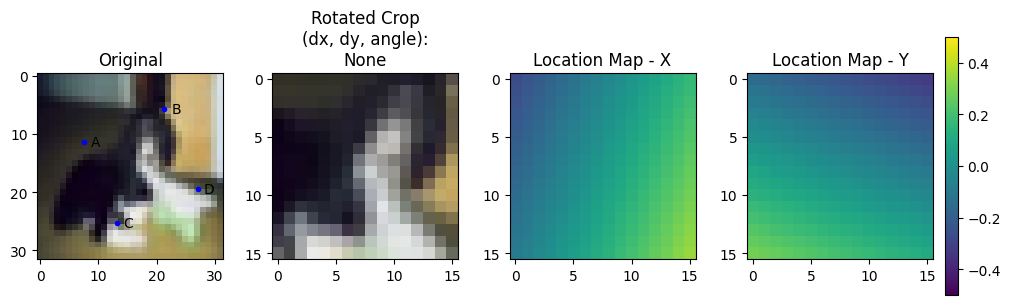

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.31811154 -0.20508364]                -         [ 0.14617527 -0.2696153 ]
    [-0.2535799  0.2592032]                -         [0.21070689 0.19467151]
Corners of crop image (pixels):
    [5.8204308 9.437324 ]                -         [20.677608   7.3723106]
    [ 7.8854427 24.294502 ]                -         [22.74262  22.229488]


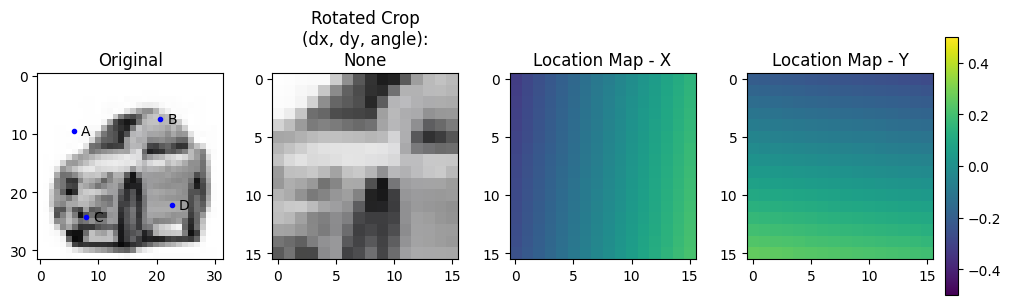

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [ 0.16954058 -0.54624826]                -         [ 0.3261913  -0.10444844]
    [-0.27225924 -0.3895975 ]                -         [-0.11560851  0.05220234]
Corners of crop image (pixels):
    [21.425299  -1.4799442]                -         [26.438122 12.65765 ]
    [7.2877045 3.5328798]                -         [12.300528 17.670475]


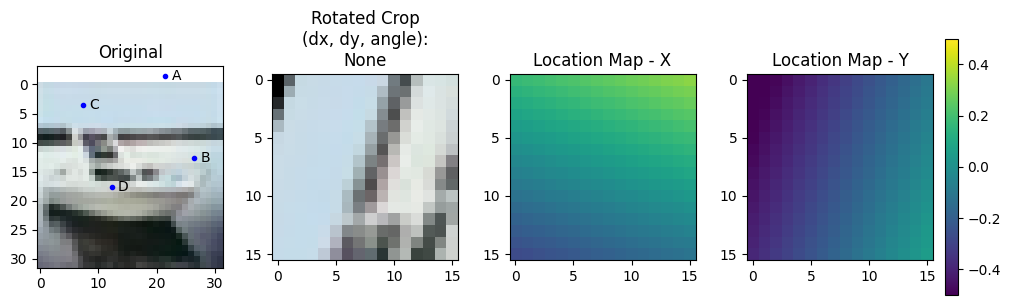

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.32014954  0.06687129]                -         [ 0.10711962 -0.12591776]
    [-0.1273605   0.49414045]                -         [0.2999087  0.30135143]
Corners of crop image (pixels):
    [ 5.7552147 18.139881 ]                -         [19.427828 11.970632]
    [11.924464 31.812494]                -         [25.597078 25.643246]


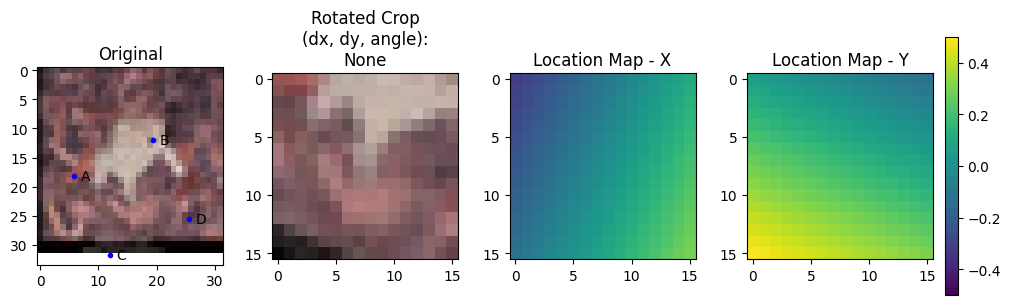

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [0.3031193  0.01358938]                -         [0.18217963 0.46646923]
    [-0.14976054 -0.10735029]                -         [-0.27070022  0.34552956]
Corners of crop image (pixels):
    [25.699818 16.43486 ]                -         [21.829748 30.927015]
    [11.207663 12.564791]                -         [ 7.337593 27.056946]


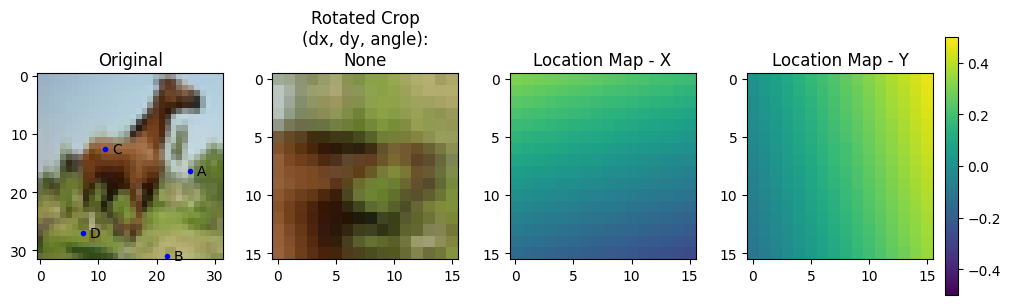

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.36974752 -0.19126877]                -         [ 0.08740216 -0.08763131]
    [-0.47338498  0.26588094]                -         [-0.01623529  0.3695184 ]
Corners of crop image (pixels):
    [4.1680794 9.879399 ]                -         [18.79687  13.195798]
    [ 0.85168076 24.50819   ]                -         [15.480471 27.824589]


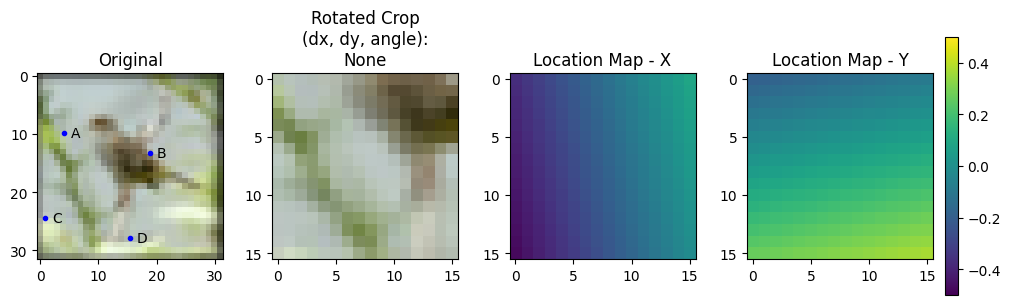

In [25]:
# plot a few examples from the dataset
def show_dataset_examples(dataset):
  for inputs, outputs in dataset.take(10):
      input, output = take_first_sample(inputs, outputs)
      show_data_sample(input, output)
show_dataset_examples(prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE))

In [32]:
def show_model_output(dataset, model, n=1):
  for inputs, true_outputs in dataset.take(n):
    pred_outputs = model(inputs)
    input, true_output = take_first_sample(inputs, true_outputs)
    _, pred_output = take_first_sample(inputs, pred_outputs)
    show_data_sample(input, true_output)
    show_data_sample(input, pred_output)

## Model


In [9]:
def location_map_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    x = layers.MultiHeadAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mha")(
        query=x2, key=x1, value=x1)

    # note: same outcome if using this instead:
    # x = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mhe")(
    #     query=x2, key=x1, value=x1)

    # Compute per-pixel local translations
    # - reshape back to (height, width, channels)
    # - 256x32 -> 16x16x32 -> 16x16x2
    x = layers.Reshape((16, 16, -1), name='head_reshape')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='head_conv')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
location_map_model().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv2 (Conv2D)         │ (None, 32, 32, 16)     │          1,168 │ x1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv2 (Conv2D)         │ (None, 16, 16, 16)     │          1,168 │ x2_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv3 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ x1_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv3 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ x2_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ x1_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv4 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ x2_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv5 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ x1_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv5 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ x2_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape (Reshape)      │ (None, 1024, 128)      │              0 │ x1_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape (Reshape)      │ (None, 256, 128)       │              0 │ x2_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_mha                  │ (None, 256, 128)       │         98,944 │ x1_reshape[0][0],      │
│ (MultiHeadAttention)      │                        │                │ x2_reshape[0][0],      │
│                           │                        │                │ x1_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_reshape (Reshape)    │ (None, 16, 16, 128)    │              0 │ head_mha[0][0]         │
├──────────────────────

 Total params: 296,258 (1.13 MB)

 Trainable params: 296,258 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model = location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 0.0370
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0364
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0368
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0369
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0365
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0364
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.0366
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0358
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0363
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0362
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0362
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0367
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0369
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0362
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━

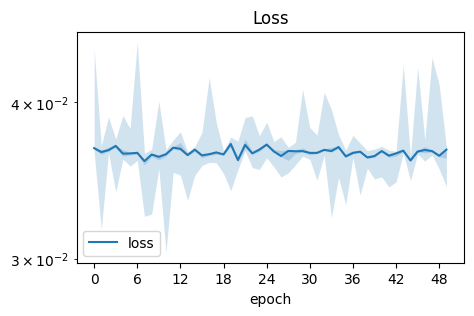

In [19]:
tinstr.plot_train_history(history)

Corners of crop image (raw):
    [-0.07846695 -0.317581  ]                -         [0.23687059 0.02924573]
    [-0.4252937  -0.00224346]                -         [-0.10995618  0.34458327]
Corners of crop image (pixels):
    [13.489058  5.837408]                -         [23.579859 16.935863]
    [ 2.3906012 15.928209 ]                -         [12.481402 27.026665]


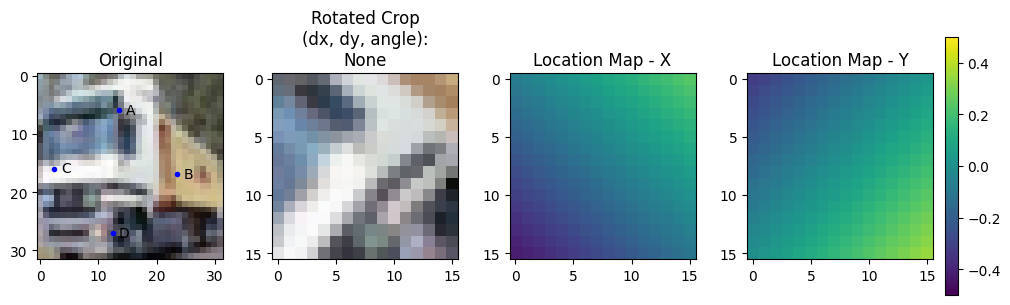

Corners of crop image (raw):
    [-0.01393928 -0.01125899]                -         [-0.01393928 -0.01125899]
    [-0.01393928 -0.01125899]                -         [-0.01393928 -0.01125899]
Corners of crop image (pixels):
    [15.553943 15.639712]                -         [15.553943 15.639712]
    [15.553943 15.639712]                -         [15.553943 15.639712]


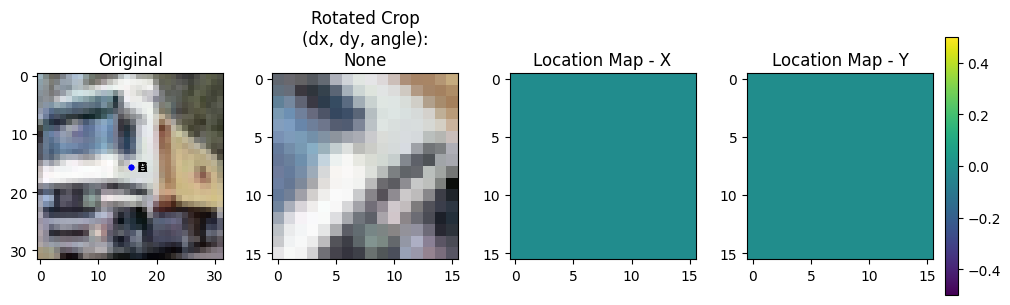

In [20]:
show_model_output(dataset, model)

outputs: (32, 16, 16, 2)
  [-0.01371427 -0.0116315 ]  -  [-0.01371427 -0.0116315 ]
  [-0.01371427 -0.0116315 ]  -  [-0.01371427 -0.0116315 ]
outputs: (32, 16, 16, 2)
  [-0.01371426 -0.01163144]  -  [-0.01371426 -0.01163144]
  [-0.01371426 -0.01163144]  -  [-0.01371426 -0.01163144]
outputs: (32, 16, 16, 2)
  [-0.01371427 -0.01163148]  -  [-0.01371427 -0.01163148]
  [-0.01371427 -0.01163148]  -  [-0.01371427 -0.01163148]
outputs: (32, 16, 16, 2)
  [-0.01371427 -0.01163145]  -  [-0.01371427 -0.01163145]
  [-0.01371427 -0.01163145]  -  [-0.01371427 -0.01163145]
outputs: (32, 16, 16, 2)
  [-0.01371428 -0.01163148]  -  [-0.01371428 -0.01163148]
  [-0.01371428 -0.01163148]  -  [-0.01371428 -0.01163148]
outputs: (32, 16, 16, 2)
  [-0.01371445 -0.01163143]  -  [-0.01371445 -0.01163143]
  [-0.01371445 -0.01163143]  -  [-0.01371445 -0.01163143]
outputs: (32, 16, 16, 2)
  [-0.01371436 -0.0116314 ]  -  [-0.01371436 -0.0116314 ]
  [-0.01371436 -0.0116314 ]  -  [-0.01371436 -0.0116314 ]
outputs: (32,

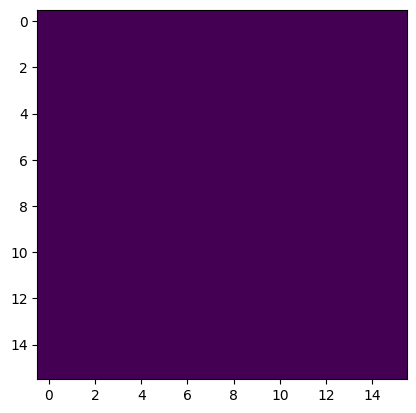

In [54]:
# plot a few predicted examples
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)

for inputs, outputs in dataset.take(10):
    outputs = model(inputs)
    print(f"outputs: {outputs.shape}")
    print(f"  {outputs[0, 0, 0, :]}  -  {outputs[0, 0, -1, :]}")
    print(f"  {outputs[0, -1, 0, :]}  -  {outputs[0, -1, -1, :]}")

for inputs, outputs in dataset.take(1):
    outputs = model(inputs)
    plt.imshow(outputs[0,:,:,0])
    plt.show()


**Instrumented training**

In [10]:
per_step=True
variables = tinstr.VariableHistoryCallback(per_step=per_step)
gradients = tinstr.GradientHistoryCallback(per_step=per_step)
outputs = tinstr.LayerOutputHistoryCallback(per_step=per_step, collection_sets=[{'layer_indices': [12]}])
output_gradients = tinstr.LayerOutputGradientHistoryCallback(per_step=per_step)

model = location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
#history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])
history = tinstr.fit(model, dataset, epochs=3, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats(per_step=per_step)])

Epoch 1/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 189ms/step - loss: 0.0364
Epoch 2/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - loss: 0.0368
Epoch 3/3
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - loss: 0.0365


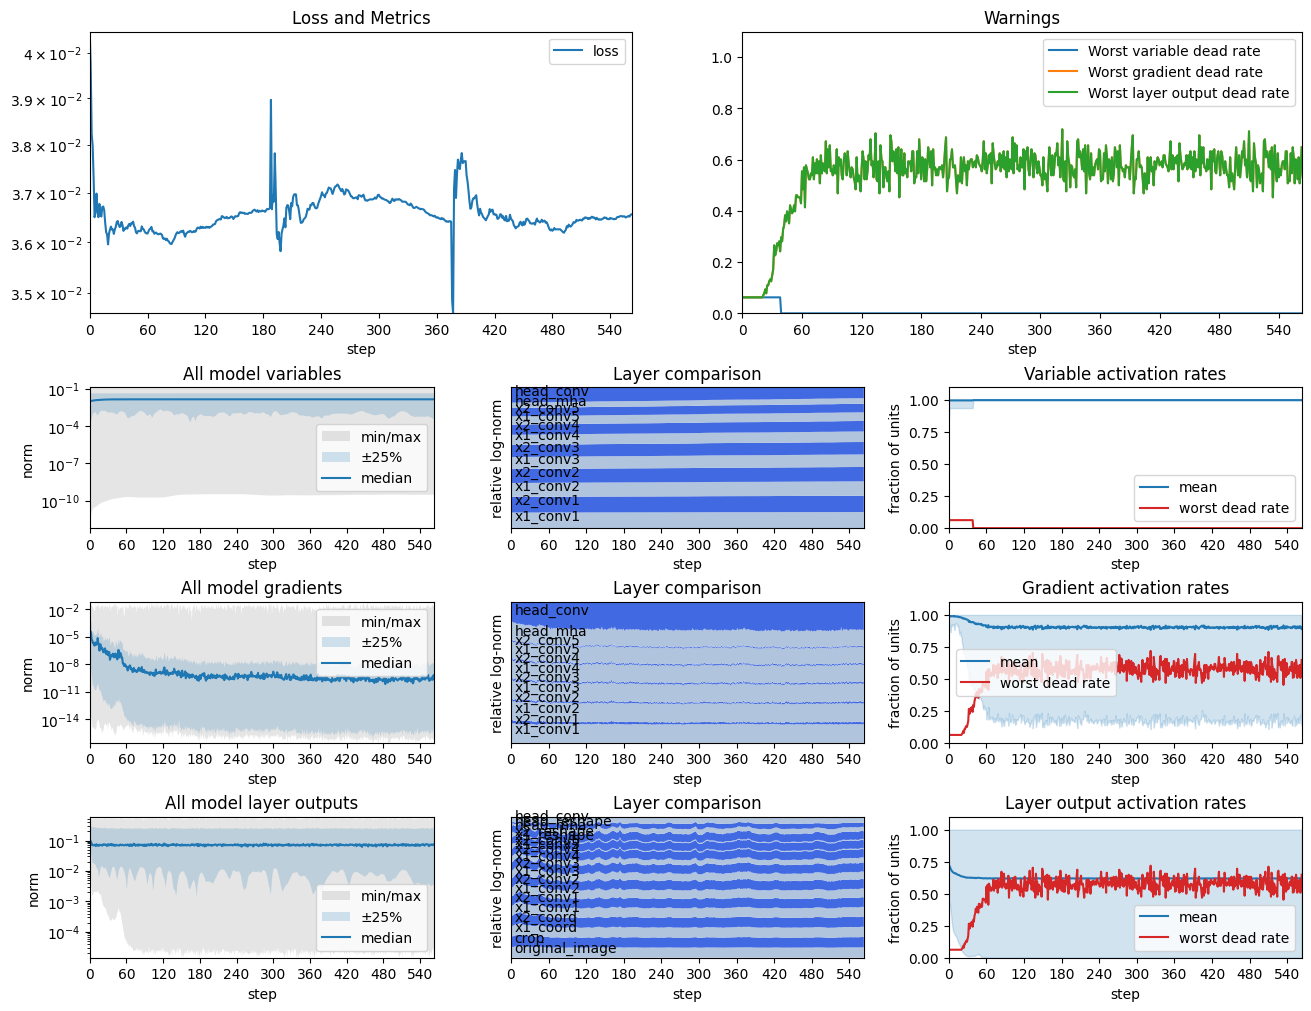

In [14]:
#tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])
tinstr.plot_history_overview([history, variables, gradients, outputs])

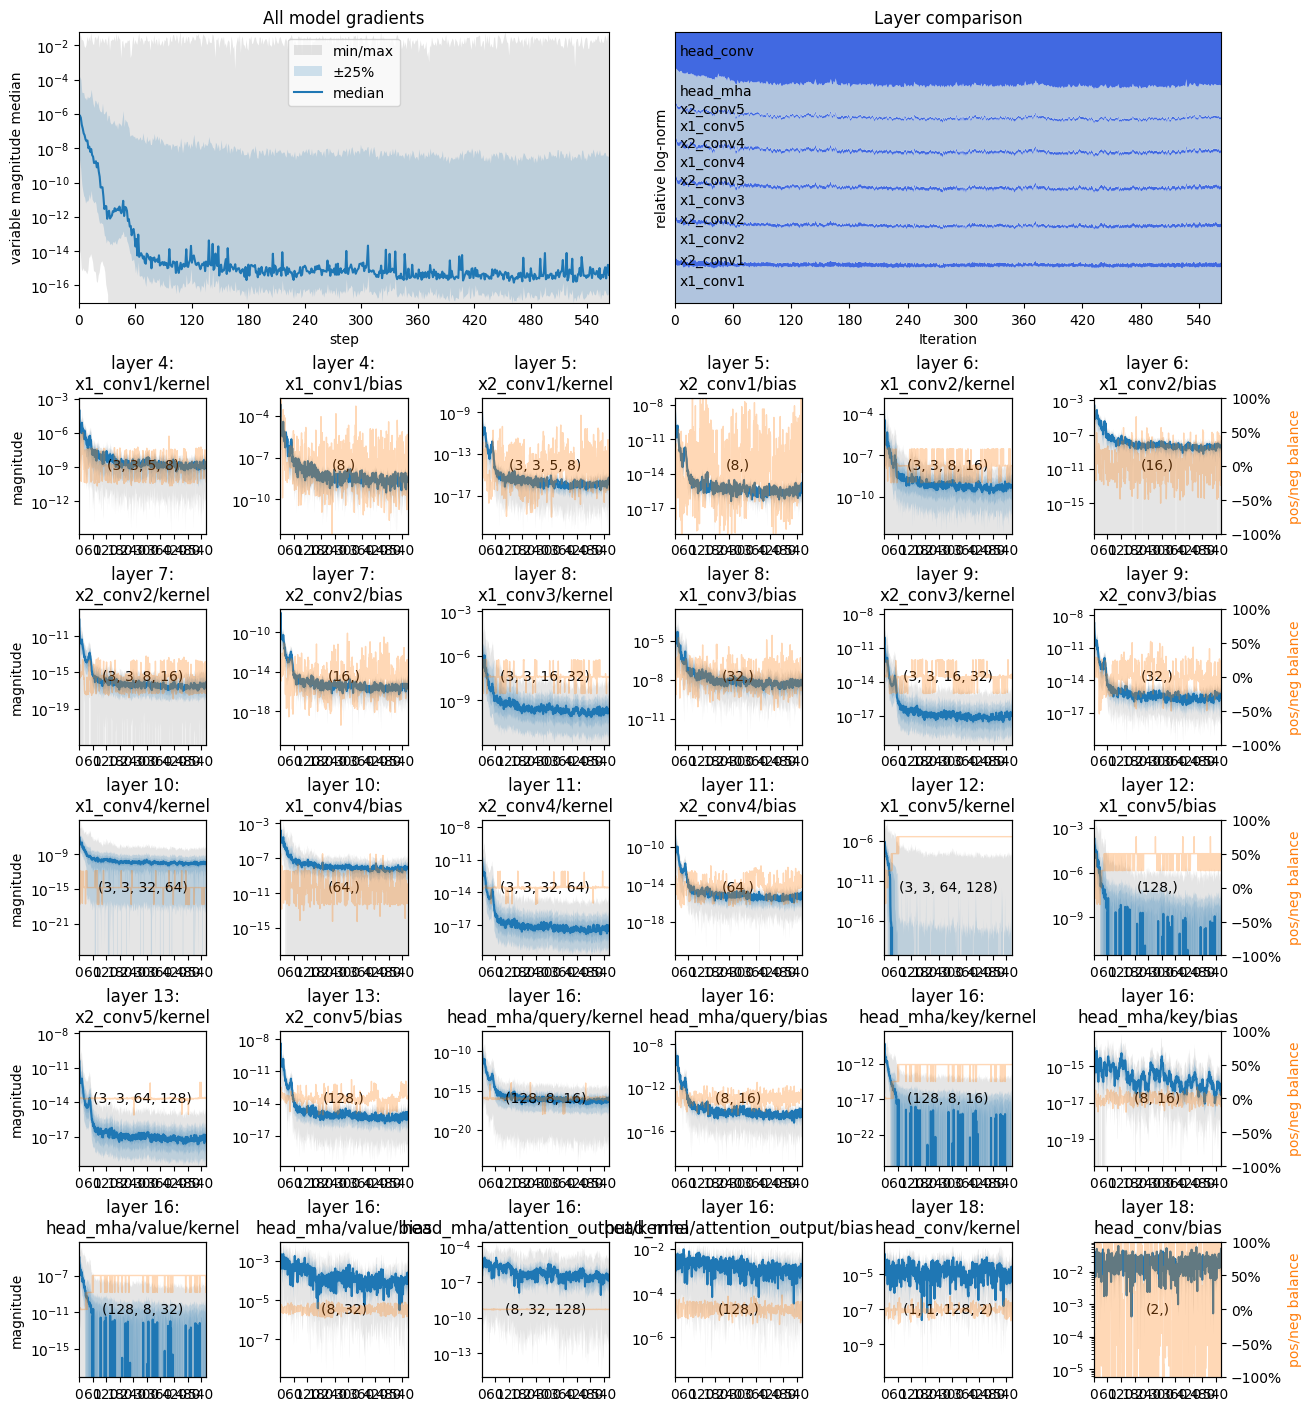

In [11]:
tinstr.plot_value_history(gradients)

In [ ]:
tinstr.plot_activity_history(gradients)

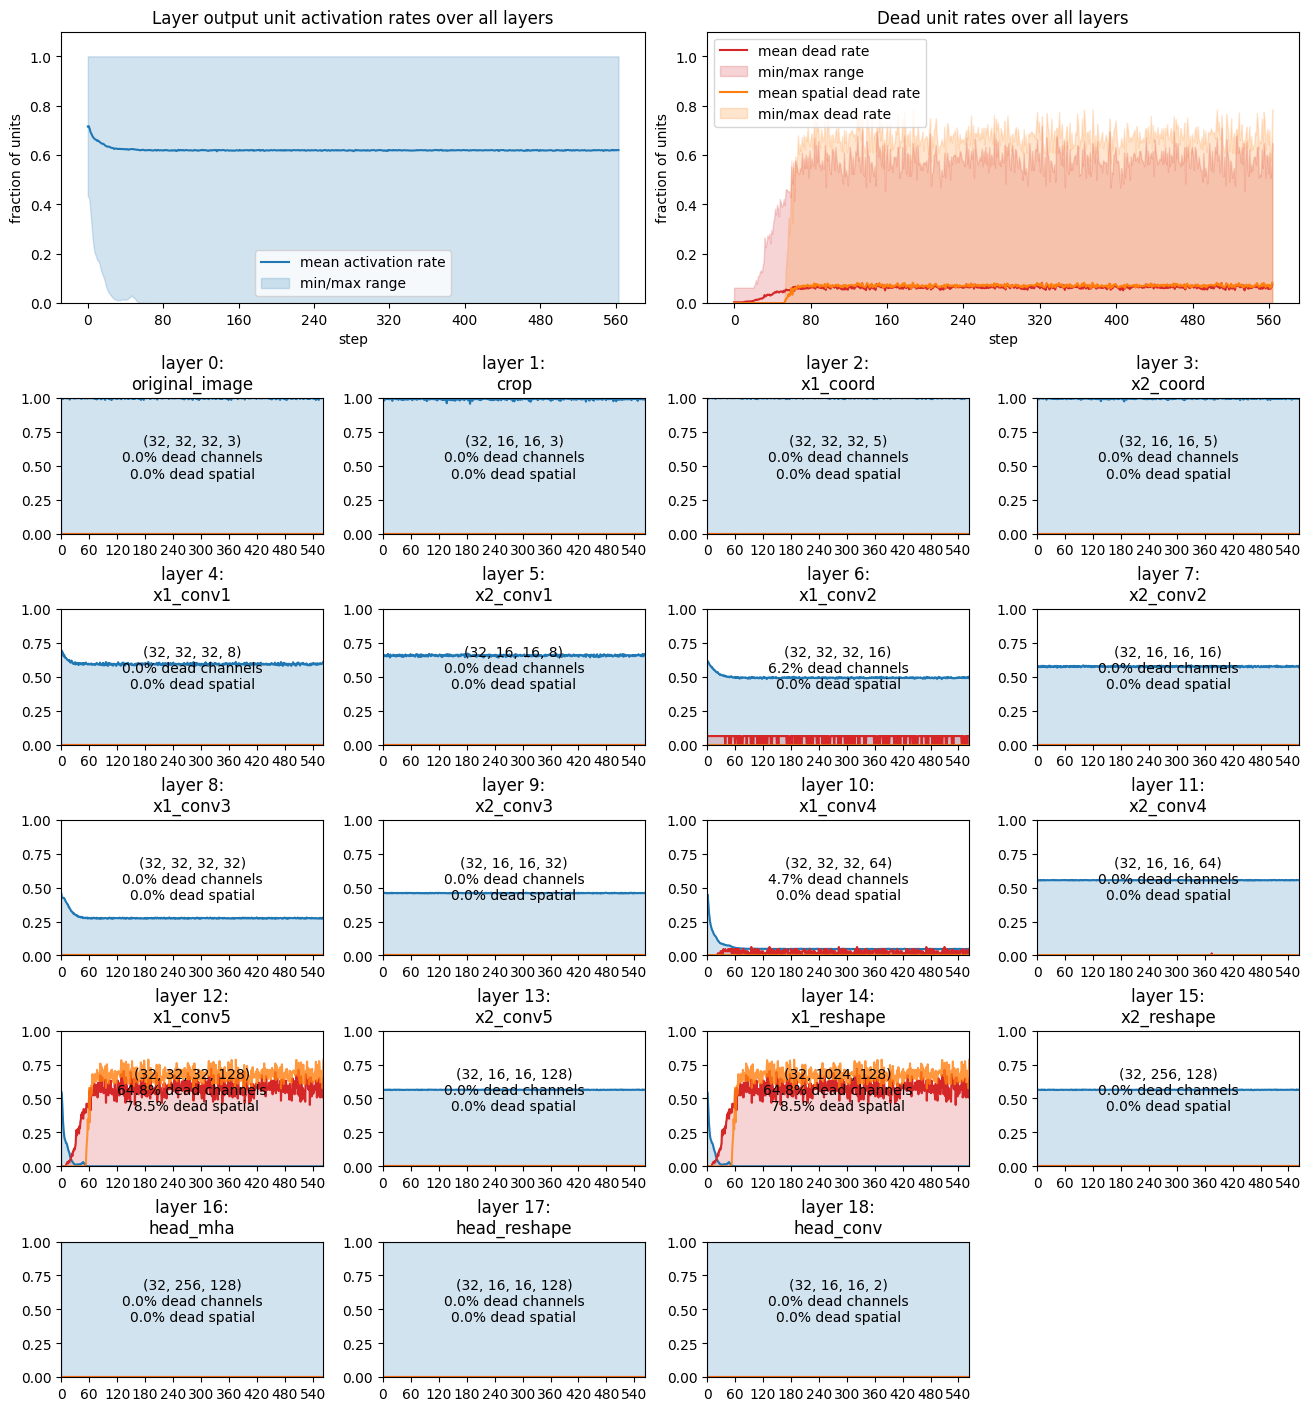

In [13]:
tinstr.plot_activity_history(outputs)

**Looking at layer 12 outputs**

In [17]:
outputs.layer_outputs[12][100].shape

TensorShape([32, 32, 32, 128])

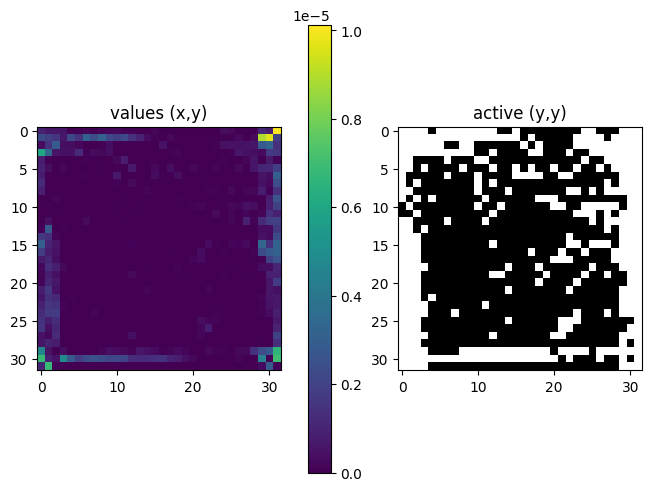

In [24]:
plt.figure(layout='constrained')

plt.subplot(1,2,1)
plt.title("values (x,y)")
plt.imshow(tf.reduce_mean(outputs.layer_outputs[12][100], axis=(0, 3)))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("active (y,y)")
plt.imshow(tf.reduce_mean(outputs.layer_outputs[12][100], axis=(0, 3)) != 0.0, cmap='gray')

plt.show()

reshaped: (32, 1024, 128)


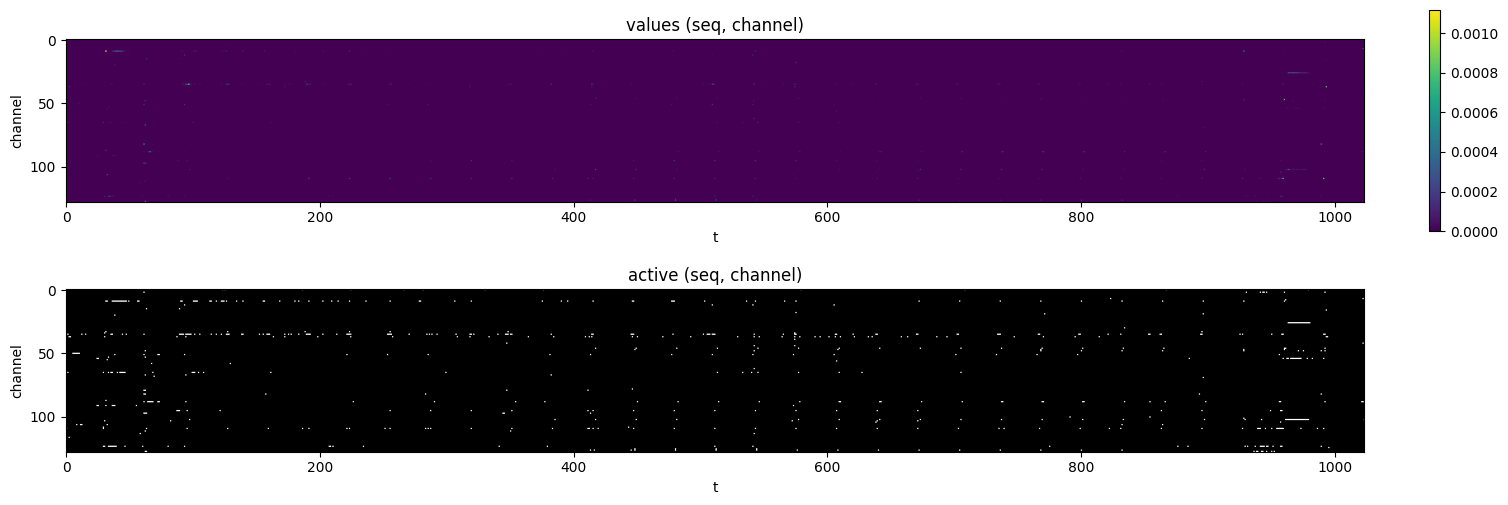

In [41]:
reshaped = tf.reshape(outputs.layer_outputs[12][100], (32, -1, 128))
print(f"reshaped: {reshaped.shape}")
plt.figure(figsize=(15,5), layout='constrained')

plt.subplot(2,1,1)
plt.title("values (seq, channel)")
plt.imshow(tf.transpose(tf.reduce_mean(reshaped, axis=0)))
plt.xlabel("t")
plt.ylabel("channel")
plt.colorbar()

plt.subplot(2,1,2)
plt.title("active (seq, channel)")
plt.imshow(tf.transpose(tf.reduce_mean(reshaped, axis=0)) != 0.0, cmap='gray')
plt.xlabel("t")
plt.ylabel("channel")

plt.show()

reshaped: (32, 1024, 128)


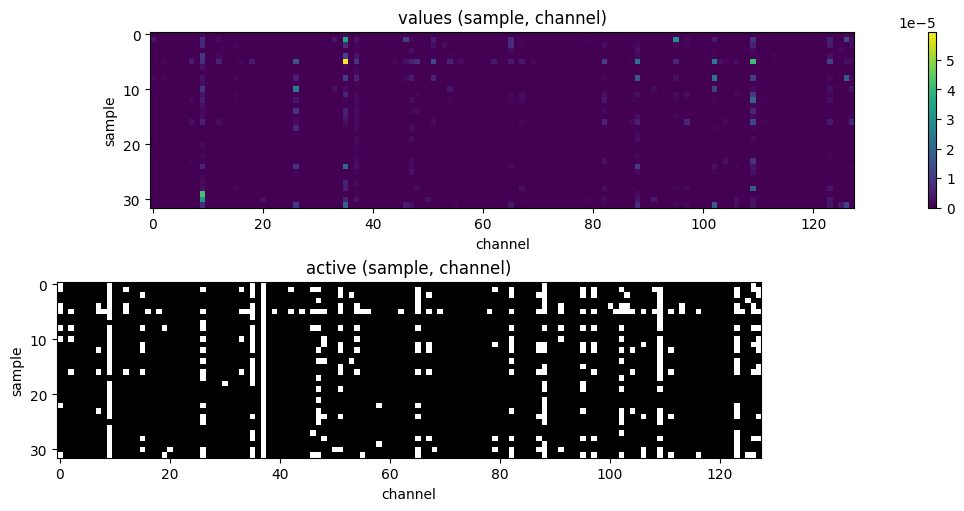

In [42]:
reshaped = tf.reshape(outputs.layer_outputs[12][100], (32, -1, 128))
print(f"reshaped: {reshaped.shape}")

plt.figure(figsize=(10,5), layout='constrained')

plt.subplot(2,1,1)
plt.title("values (sample, channel)")
plt.imshow(tf.reduce_mean(reshaped, axis=1))
plt.xlabel("channel")
plt.ylabel("sample")
plt.colorbar()

plt.subplot(2,1,2)
plt.title("active (sample, channel)")
plt.imshow(tf.reduce_mean(reshaped, axis=1) != 0.0, cmap='gray')
plt.xlabel("channel")
plt.ylabel("sample")

plt.show()

**Analysis**

I think the problem is that the loss landscape is extremely rough, and the optimal region is extremely narrow (_a la_ Li et al., 2018). I suspect it's bouncing past the optimal region early on, and into rough territory that causes it to misbehave.
On the face of things, it's got into a weird region that causes it to then move rapidly towards negative Z-values. This is likely because it's unable to shift the loss using the values that really matter, and so it's instead trying to reduce the loss by forcing the lower-utility values heavily negative.

Despite that, the gradients look fairly stable. It's not like they're wildly oscillation in sign.

Actually, the sign is perhaps an indication. Notice that the vast majority of x1_conv5 gradients are positive, and that it shifts quickly into this state. That will push the weights negative....actually, that's probably just a factor of the gradients collapsing to zero. I think the pos/neg balance is biased to ignore zeros so it'll bias towards the few positive values that remain.

References:
* Li, H., Xu, Z., Taylor, G., Studer, C., Goldstein, T. (2018). Visualizing the Loss Landscape of Neural Nets. NIPS 2018.

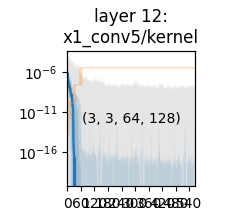

**Possible Solutions**

Li et al. (2018), suggest that skip connections improve training efficiency by smoothing out the loss landscape and ensuring that the optimal linear-ish region is broader. This inspires a similar idea for this problem.

* Conceptually I assume that the conv layers are doing the typical thing of finding every higher-level features. But I don't know that such a thing is happening.
* Given the problems, one can assume that this isn't happening. And consequently the MHA step fails to operate correctly because it's got the wrong kind of inputs.
* A solution is to apply a form of regression -- in this case, via AutoEncoder.
* So for each of the x1 and x2 input arms, I add extra decoder layers to reproduce their original input...including the spatial coords. This regularises the features -- basically enforcing human-designed feature engineering.

## Attention as Position
Note: in implementing this, I found that the `attn_scores` matrix returend by layers.MultiHeadAttention wasn't correct for this cross-attention task with differently lengthed sequences. I wasn't able to figure out what was going wrong.

So I ended up just re-implementing the MHA instead.

In [ ]:
class AttendedValues(layers.Layer):
  def __init__(self, head_reduction=None, **kwargs):
    super().__init__(**kwargs)
    self.head_reduction = head_reduction

  def call(self, attn_scores, values):
    """
    Args:
      - attn_scores: (batch, query_tokens, key_tokens)
      - values: (key_tokens, ..any..)
    Returns:
      - (batch, query_tokens, ..any..)
    """
    if self.head_reduction == 'mean':
        attn_scores = tf.reduce_mean(attn_scores, axis=1)  # (batch, heads, query_tokens, key_tokens) -> (batch, query_tokens, key_tokens)
    elif self.head_reduction is not None:
        raise ValueError(f"unknown head_reduction: {self.head_reduction}")
    return tf.linalg.matmul(attn_scores, values)

    def get_config(self):
        config = super().get_config()
        config.update({
            "head_reduction": self.head_reduction
        })
        return config

def attn_as_location_map_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    # - then average across attention heads: (batch, heads, 256, 1024) -> -> (batch, 256, 1024)
    # print(f"x1: {x1.shape}")
    # print(f"x2: {x2.shape}")
    mha = CrossAttention(num_heads=8, key_dim=16, value_dim=32, return_value=False, return_attention_scores=True, name="head_mha")
    attn_scores = mha(query=x2, key=x1, value=x1)  # (batch, 256, 32), (batch, 8, 256, 1024)
    # print(f"attn_output: {attn_output.shape}")
    # print(f"attn_scores: {attn_scores.shape}")

    # Generate normalized position meshgrid for x1 (32x32 grid in range -0.5..+0.5)
    # Compute weighted sum: Attention weights * Position grid
    grid_x, grid_y = tf.meshgrid(
        tf.linspace(-0.5, 0.5, 32),
        tf.linspace(-0.5, 0.5, 32),
        indexing="xy"
    )
    pos_grid = tf.stack([grid_x, grid_y], axis=-1)  # (32, 32, 2)
    pos_grid = tf.reshape(pos_grid, [1024, 2])  # Flatten to (1024, 2)
    position_map = AttendedValues(head_reduction='mean', name='head_av')(attn_scores, pos_grid)

    # Output
    x = layers.Reshape((16, 16, -1), name='head_reshape')(position_map)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
attn_as_location_map_model().summary()

In [ ]:
model = attn_as_location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

In [ ]:
tinstr.plot_train_history(history)

In [ ]:
show_model_output(dataset, model)

**Equivalent but with more capacity**

This proves to be no better, or even a little worse.

In [ ]:
def attn_as_location_map_model2():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1a')(x1)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1b')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2a')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2b')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3a')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3b')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4a')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4b')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5a')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5b')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1a')(x2)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1b')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2a')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2b')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3a')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3b')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4a')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4b')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5a')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5b')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    # - then average across attention heads: (batch, heads, 256, 1024) -> -> (batch, 256, 1024)
    # print(f"x1: {x1.shape}")
    # print(f"x2: {x2.shape}")
    mha = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mha")
    attn_output, attn_scores = mha(query=x2, key=x1, value=x1, return_attention_scores=True)  # (batch, 256, 32), (batch, 8, 256, 1024)
    # print(f"attn_output: {attn_output.shape}")
    # print(f"attn_scores: {attn_scores.shape}")

    # Generate normalized position meshgrid for x1 (32x32 grid in range -0.5..+0.5)
    # Compute weighted sum: Attention weights * Position grid
    grid_x, grid_y = tf.meshgrid(
        tf.linspace(-0.5, 0.5, 32),
        tf.linspace(-0.5, 0.5, 32),
        indexing="xy"
    )
    pos_grid = tf.stack([grid_x, grid_y], axis=-1)  # (32, 32, 2)
    pos_grid = tf.reshape(pos_grid, (1024, 2))  # Flatten to (1024, 2)
    position_map = AttendedValues(head_reduction='mean', name='head_av')(attn_scores, pos_grid)

    # Output
    x = layers.Reshape((16, 16, -1), name='head_reshape')(position_map)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
attn_as_location_map_model2().summary()

In [ ]:
model = attn_as_location_map_model2()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

In [ ]:
tinstr.plot_train_history(history)

In [ ]:
show_model_output(dataset, model)

## Dumb model

In [ ]:
def dumb_location_map_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> 16x16x128
    x1 = CoordConv()(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5')(x1)
    x1 = layers.MaxPool2D(pool_size=(2, 2), padding='same', name='x1_maxpool1')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128
    x2 = CoordConv()(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5')(x2)

    # Cross-attention to spatial
    x = layers.Concatenate()([x1, x2])
    x = layers.Conv2D(filters=32, kernel_size=1, name='head_conv1')(x)
    x = layers.Conv2D(filters=32, kernel_size=1, name='head_conv2')(x)
    x = layers.Conv2D(filters=32, kernel_size=1, name='head_conv3')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='head_conv4')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=x)

# Uncomment if you just want to see the model summary
dumb_location_map_model().summary()

In [ ]:
model = dumb_location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

In [ ]:
show_model_output(dataset, model)

**Instrumentd training**

In [ ]:
variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = dumb_location_map_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

In [ ]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

## Original model with AutoEncoder regularization
Now let's try an earlier idea about using an auto-encoder to regularize the features to actually be features.

In [9]:
class MSELossLayer(layers.Layer):
    def __init__(self, **kwargs):
       super().__init__(**kwargs)

    def call(self, y_true, y_pred):
      # mean over all but batch dim
      loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=tf.range(1, tf.rank(y_true)))
      self.add_loss(loss)
      return loss

def location_map_aereg_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 32x32x3 -> 32x32x5 -> ... -> 32x32x128 -> (32x32)x128 = 1024x128
    x1 = CoordConv(name='x1_coord')(original_input)
    x1_coord = x1
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_conv2')(x1)
    x1 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_conv3')(x1)
    x1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_conv4')(x1)
    x1 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x1_conv5')(x1)
    x1 = layers.Reshape((-1, 128), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    # - adds spatial information
    # - convolves for several layers to build up high-level features but at full resolution
    # - reshapes to (tokens,channels) for input to attention
    # - 16x16x3 -> 16x16x5 -> ... -> 16x16x128 -> (16x16)x128 = 256x128
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2_coord = x2
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_conv2')(x2)
    x2 = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_conv3')(x2)
    x2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_conv4')(x2)
    x2 = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same', name='x2_conv5')(x2)
    x2 = layers.Reshape((-1, 128), name='x2_reshape')(x2)

    # AutoEncoder decoder stack for x1
    x1_ae = layers.Reshape((32, 32, 128), name='x1_ae_reshape')(x1)
    x1_ae = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x1_ae_conv1')(x1_ae)
    x1_ae = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x1_ae_conv2')(x1_ae)
    x1_ae = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x1_ae_conv3')(x1_ae)
    x1_ae = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_ae_conv4')(x1_ae)
    x1_ae = layers.Conv2D(filters=5, kernel_size=3, padding='same', name='x1_ae')(x1_ae)
    #x1_ae_loss = MSELossLayer()(x1_coord, x1_ae)
    #print(f"x1_ae: {x1_ae.shape}, x1_ae_loss: {x1_ae_loss.shape}")

    # AutoEncoder decoder stack for x2
    x2_ae = layers.Reshape((16, 16, 128), name='x2_ae_reshape')(x2)
    x2_ae = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same', name='x2_ae_conv1')(x2_ae)
    x2_ae = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', name='x2_ae_conv2')(x2_ae)
    x2_ae = layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', name='x2_ae_conv3')(x2_ae)
    x2_ae = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_ae_conv4')(x2_ae)
    x2_ae = layers.Conv2D(filters=5, kernel_size=3, padding='same', name='x2_ae')(x2_ae)
    #x2_ae_loss = MSELossLayer()(x2_coord, x2_ae)


    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    x = layers.MultiHeadAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mha")(
        query=x2, key=x1, value=x1)

    # note: same outcome if using this instead:
    # x = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mhe")(
    #     query=x2, key=x1, value=x1)

    # Compute per-pixel local translations
    # - reshape back to (height, width, channels)
    # - 256x32 -> 16x16x32 -> 16x16x2
    x = layers.Reshape((16, 16, -1), name='head_reshape')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='location_map')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=[x, x1_ae, x2_ae])

# dataset map function
def ds_with_aereg(inputs, outputs):
  (original_image, crop) = inputs
  location_map = outputs
  x1_ae = CoordConv()(original_image)
  x2_ae = CoordConv()(crop)
  #print(f"original_image: {type(original_image)} x {original_image.shape}, x1_ae: {type(x1_ae)} x {x1_ae.shape}")
  return inputs, (location_map, x1_ae, x2_ae)

# Uncomment if you just want to see the model summary
location_map_aereg_model().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv2 (Conv2D)         │ (None, 32, 32, 16)     │          1,168 │ x1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv2 (Conv2D)         │ (None, 16, 16, 16)     │          1,168 │ x2_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv3 (Conv2D)         │ (None, 32, 32, 32)     │          4,640 │ x1_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv3 (Conv2D)         │ (None, 16, 16, 32)     │          4,640 │ x2_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ x1_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv4 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ x2_conv3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv5 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ x1_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv5 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ x2_conv4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape (Reshape)      │ (None, 1024, 128)      │              0 │ x1_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape (Reshape)      │ (None, 256, 128)       │              0 │ x2_conv5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_ae_reshape (Reshape)   │ (None, 32, 32, 128)    │              0 │ x1_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_ae_reshape (Reshape)   │ (None, 16, 16, 128)    │              0 │ x2_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_ae_conv1 (Conv2D)      │ (None, 32, 32, 64)     │         73,792 │ x1_ae_reshape[0][0]    │
├──────────────────────

 Total params: 493,068 (1.88 MB)

 Trainable params: 493,068 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model = location_map_aereg_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        'location_map': 'mse',
        'x1_ae': 'mse',
        'x2_ae': 'mse',
    }
)
dataset = prepared_dataset('location_map').take(6000).batch(32).map(ds_with_aereg).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - location_map_loss: 0.0369 - loss: 0.1680 - x1_ae_loss: 0.0693 - x2_ae_loss: 0.0618
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - location_map_loss: 0.0369 - loss: 0.0471 - x1_ae_loss: 0.0054 - x2_ae_loss: 0.0049
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - location_map_loss: 0.0368 - loss: 0.0422 - x1_ae_loss: 0.0023 - x2_ae_loss: 0.0031
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - location_map_loss: 0.0363 - loss: 0.0400 - x1_ae_loss: 0.0018 - x2_ae_loss: 0.0019
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - location_map_loss: 0.0367 - loss: 0.0395 - x1_ae_loss: 0.0015 - x2_ae_loss: 0.0013
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - location_map_loss: 0.0372 - loss: 0.0395 - x1_ae_loss: 0.0013 - x2_ae_loss: 0.0010
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - location_map_loss: 0.0365 - loss: 0.0385 - x1_ae_loss: 0.0013 - x2_ae_loss: 7.6699e-04
Epoch 8/50
188/188 ━━━━

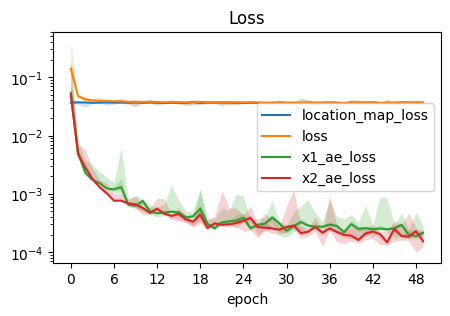

In [34]:
tinstr.plot_train_history(history)

pred_output: <class 'list'> x 3
Corners of crop image (raw):
    [-0.34894156  0.00401235]                -         [-0.05178478 -0.3585127 ]
    [0.01358348 0.30116916]                -         [ 0.3107403  -0.06135595]
Corners of crop image (pixels):
    [ 4.83387  16.128395]                -         [14.342887   4.5275936]
    [16.434671 25.637413]                -         [25.94369 14.03661]


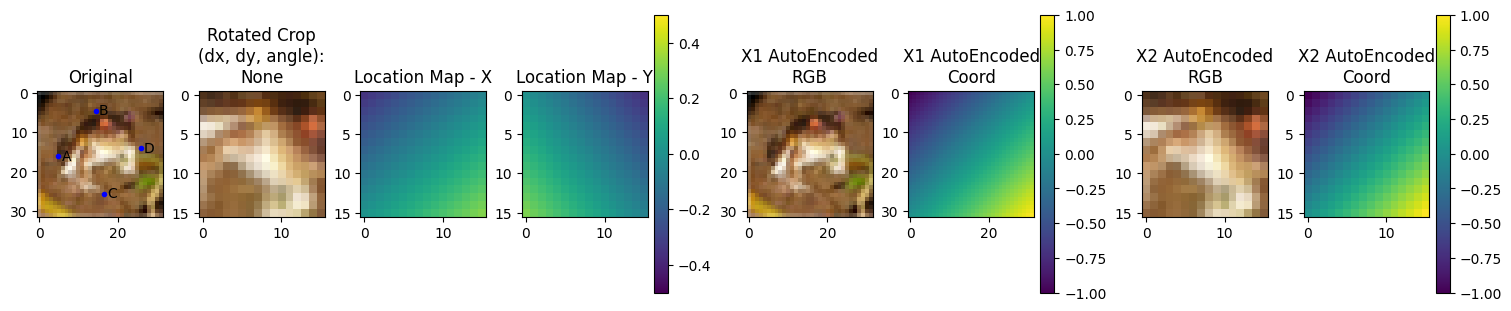

Corners of crop image (raw):
    [-0.00988462 -0.00836781]                -         [-0.00988459 -0.00836793]
    [-0.00988467 -0.00836765]                -         [-0.00988462 -0.00836782]
Corners of crop image (pixels):
    [15.683692 15.73223 ]                -         [15.683693 15.732226]
    [15.683691 15.732235]                -         [15.683692 15.732229]


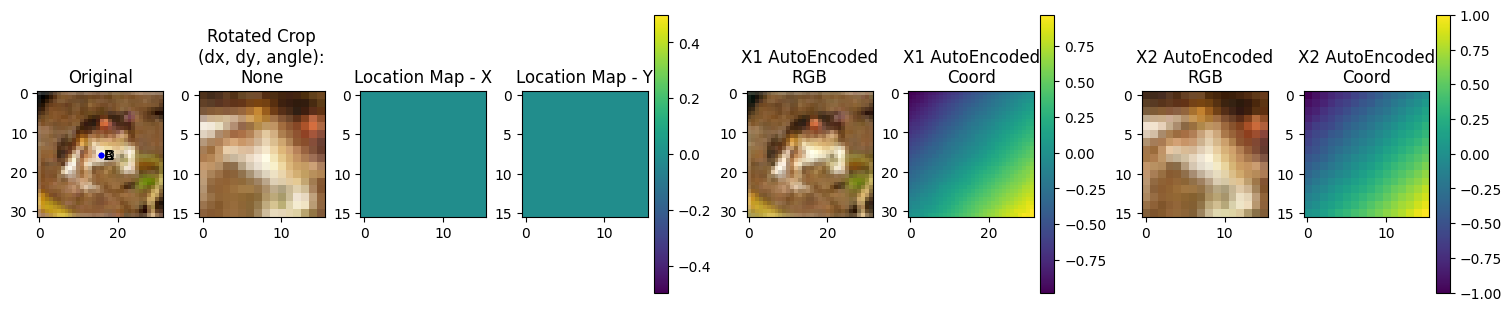

In [35]:
def show_data_sample_aereg(inputs, outputs):
  """
  Copes with usage any of:
  - show_data_sample((image, cropped), transform)
  - show_data_sample((image, cropped), location_map)
  - show_data_sample((image, cropped), (transform, location_map))
  """
  (image, cropped) = inputs
  (location_map, x1_ae, x2_ae) = outputs
  transform = None

  plt.figure(figsize=(15, 3), layout='constrained')
  cols = 4 if location_map is not None else 2
  cols += 4

  plt.subplot(1, cols, 1)
  plt.title("Original")
  plt.imshow(image)
  if transform is not None:
    draw_crop_template(image, transform)
  if location_map is not None:
    img_size_factor = np.array([image.shape[1], image.shape[0]])
    img_centre = np.array([image.shape[1] // 2, image.shape[0] // 2])
    a = location_map[0, 0, :] * img_size_factor + img_centre
    b = location_map[0, -1, :] * img_size_factor + img_centre
    c = location_map[-1, 0, :] * img_size_factor + img_centre
    d = location_map[-1, -1, :] * img_size_factor + img_centre
    points = np.array([a, b, c, d])
    plt.plot(points[:,0], points[:,1], 'b.')
    plt.text(a[0]+2, a[1], "A", horizontalalignment='center', verticalalignment='center')
    plt.text(b[0]+2, b[1], "B", horizontalalignment='center', verticalalignment='center')
    plt.text(c[0]+2, c[1], "C", horizontalalignment='center', verticalalignment='center')
    plt.text(d[0]+2, d[1], "D", horizontalalignment='center', verticalalignment='center')

    print(f"Corners of crop image (raw):")
    print(f"    {location_map[0, 0, :]}                -         {location_map[0, -1, :]}")
    print(f"    {location_map[-1, 0, :]}                -         {location_map[-1, -1, :]}")

    print(f"Corners of crop image (pixels):")
    print(f"    {a}                -         {b}")
    print(f"    {c}                -         {d}")

    # all points:
    #xs = location_map[..., 0] * img_size_factor[0] + img_centre[0]
    #ys = location_map[..., 1] * img_size_factor[1] + img_centre[1]
    #plt.plot(xs, ys, 'b.')

  plt.subplot(1, cols, 2)
  plt.title(f"Rotated Crop\n(dx, dy, angle):\n{transform}")
  plt.imshow(cropped)

  if location_map is not None:
    plt.subplot(1, cols, 3)
    plt.title(f"Location Map - X")
    plt.imshow(location_map[:,:,0], vmin=-0.5, vmax=+0.5)

    plt.subplot(1, cols, 4)
    plt.title(f"Location Map - Y")
    plt.imshow(location_map[:,:,1], vmin=-0.5, vmax=+0.5)
    plt.colorbar()

  plt.subplot(1, cols, 5)
  plt.title(f"X1 AutoEncoded\nRGB")
  plt.imshow(x1_ae[:, :, 0:3])

  plt.subplot(1, cols, 6)
  plt.title(f"X1 AutoEncoded\nCoord")
  plt.imshow(tf.reduce_sum(x1_ae[:, :, 3:], axis=-1))
  plt.colorbar()

  plt.subplot(1, cols, 7)
  plt.title(f"X2 AutoEncoded\nRGB")
  plt.imshow(x2_ae[:, :, 0:3])

  plt.subplot(1, cols, 8)
  plt.title(f"X2 AutoEncoded\nCoord")
  plt.imshow(tf.reduce_sum(x2_ae[:, :, 3:], axis=-1))
  plt.colorbar()

  plt.show()

def show_model_output_aereg(dataset, model):
  for inputs, true_outputs in dataset.take(1):
    pred_outputs = model(inputs)

    input, true_output = take_first_sample(inputs, true_outputs)
    _, pred_output = take_first_sample(inputs, pred_outputs)
    #(location_map, x1_ae, x2_ae) = output_true
    #(location_map_pred, x1_ae_pred, x2_ae_pred) = pred_outputs
    print(f"pred_output: {type(pred_outputs)} x {len(pred_outputs)}")

    show_data_sample_aereg(input, true_output)
    show_data_sample_aereg(input, pred_output)

show_model_output_aereg(dataset, model)

outputs: (32, 16, 16, 2)
  [-0.00988462 -0.00836783]  -  [-0.0098846  -0.00836788]
  [-0.00988473 -0.00836747]  -  [-0.0098846  -0.00836789]
outputs: (32, 16, 16, 2)
  [-0.00968747 -0.00902447]  -  [-0.00968748 -0.00902445]
  [-0.0096876  -0.00902404]  -  [-0.00968744 -0.00902456]
outputs: (32, 16, 16, 2)
  [-0.00973504 -0.0088782 ]  -  [-0.00973498 -0.0088784 ]
  [-0.00973517 -0.00887774]  -  [-0.00973496 -0.00887849]
outputs: (32, 16, 16, 2)
  [-0.00969555 -0.00899721]  -  [-0.00969544 -0.00899761]
  [-0.00969554 -0.00899726]  -  [-0.00969544 -0.0089976 ]
outputs: (32, 16, 16, 2)
  [-0.0097167  -0.00892327]  -  [-0.00971668 -0.00892334]
  [-0.0097167  -0.00892325]  -  [-0.00971682 -0.00892286]
outputs: (32, 16, 16, 2)
  [-0.00946805 -0.0097763 ]  -  [-0.00946799 -0.00977652]
  [-0.00946803 -0.00977639]  -  [-0.00946791 -0.0097768 ]
outputs: (32, 16, 16, 2)
  [-0.00947338 -0.00975865]  -  [-0.00947331 -0.00975893]
  [-0.00947319 -0.00975937]  -  [-0.00947314 -0.00975954]
outputs: (32,

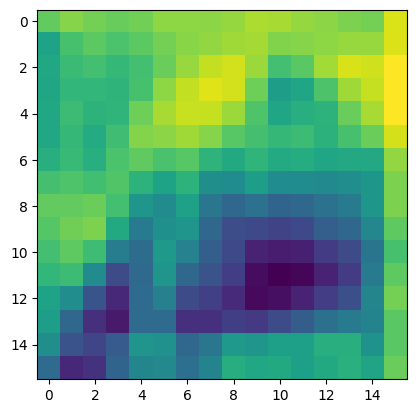

In [36]:
# plot a few predicted examples
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)

for inputs, outputs in dataset.take(10):
    outputs = model(inputs)
    (location_maps, x1_ae, x2_ae) = outputs
    print(f"outputs: {location_maps.shape}")
    print(f"  {location_maps[0, 0, 0, :]}  -  {location_maps[0, 0, -1, :]}")
    print(f"  {location_maps[0, -1, 0, :]}  -  {location_maps[0, -1, -1, :]}")

for inputs, outputs in dataset.take(1):
    outputs = model(inputs)
    (location_maps, x1_ae, x2_ae) = outputs
    plt.imshow(location_maps[0,:,:,0])
    plt.show()

**Instrumented training**

In [10]:
per_step=False
variables = tinstr.VariableHistoryCallback(per_step=per_step)
gradients = tinstr.GradientHistoryCallback(per_step=per_step)
outputs = tinstr.LayerOutputHistoryCallback(per_step=per_step)
#outputs = tinstr.LayerOutputHistoryCallback(per_step=per_step, collection_sets=[{'layer_indices': [12]}])
output_gradients = tinstr.LayerOutputGradientHistoryCallback(per_step=per_step)

model = location_map_aereg_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        'location_map': 'mse',
        'x1_ae': 'mse',
        'x2_ae': 'mse',
    }
)
dataset = prepared_dataset('location_map').take(6000).batch(32).map(ds_with_aereg).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=5, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])
#history = tinstr.fit(model, dataset, epochs=3, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats(per_step=per_step)])

Epoch 1/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - location_map_loss: 0.0373 - loss: 0.1510 - x1_ae_loss: 0.0615 - x2_ae_loss: 0.0521


Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - location_map_loss: 0.0365 - loss: 0.0468 - x1_ae_loss: 0.0047 - x2_ae_loss: 0.0056
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - location_map_loss: 0.0367 - loss: 0.0423 - x1_ae_loss: 0.0027 - x2_ae_loss: 0.0029
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - location_map_loss: 0.0367 - loss: 0.0408 - x1_ae_loss: 0.0020 - x2_ae_loss: 0.0021
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - location_map_loss: 0.0361 - loss: 0.0396 - x1_ae_loss: 0.0016 - x2_ae_loss: 0.0019


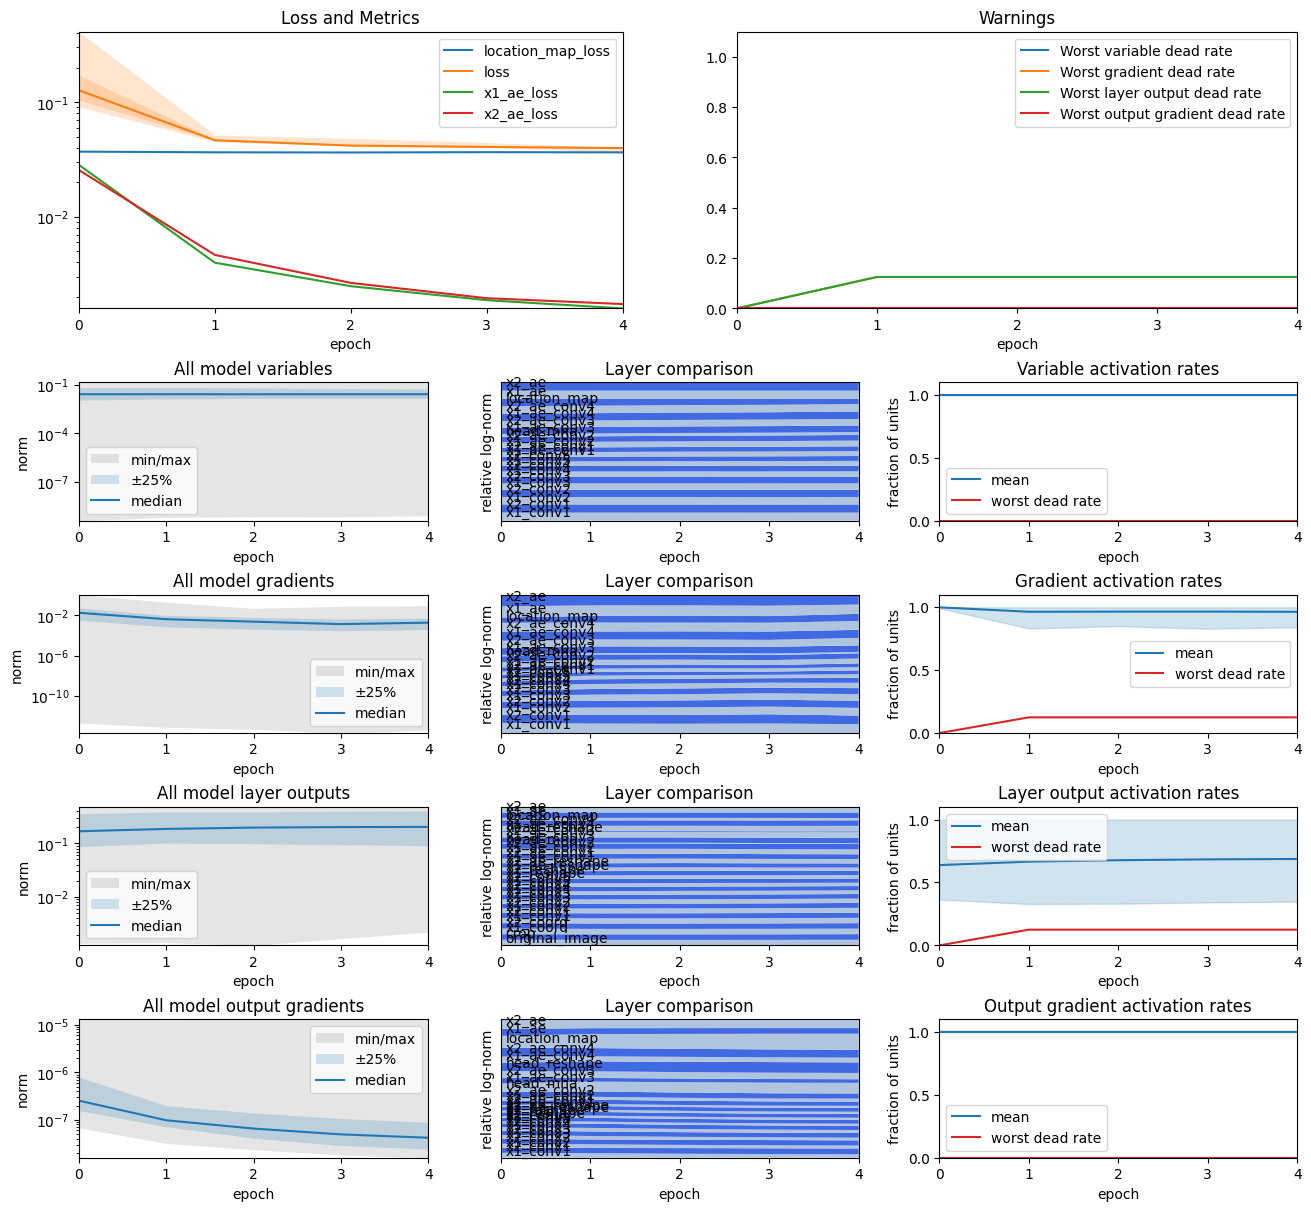

In [11]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

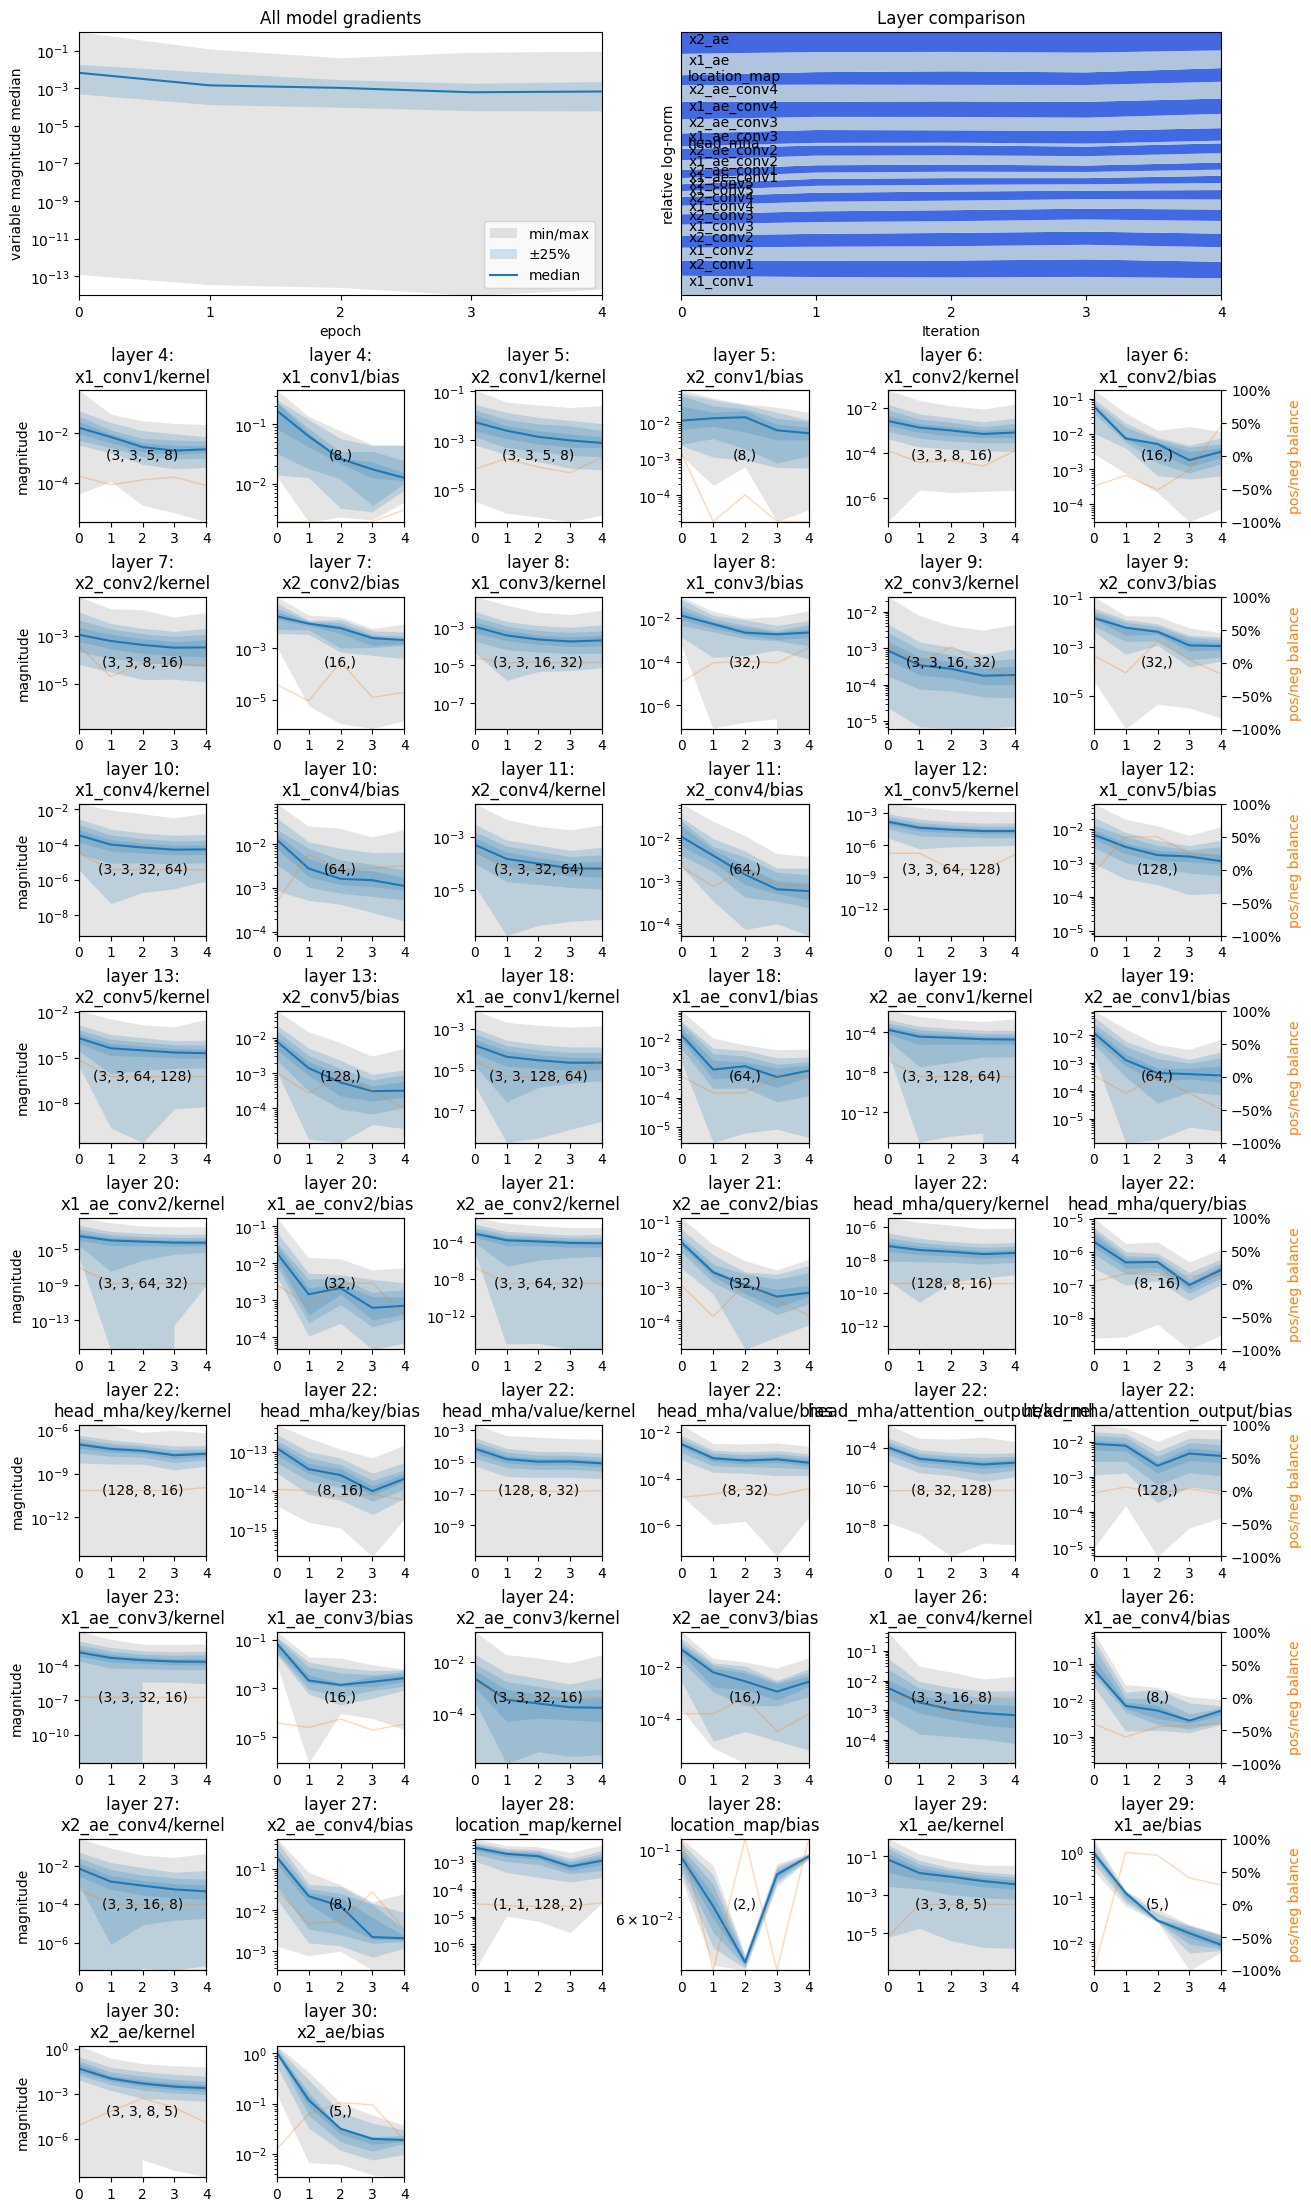

In [27]:
tinstr.plot_value_history(gradients)

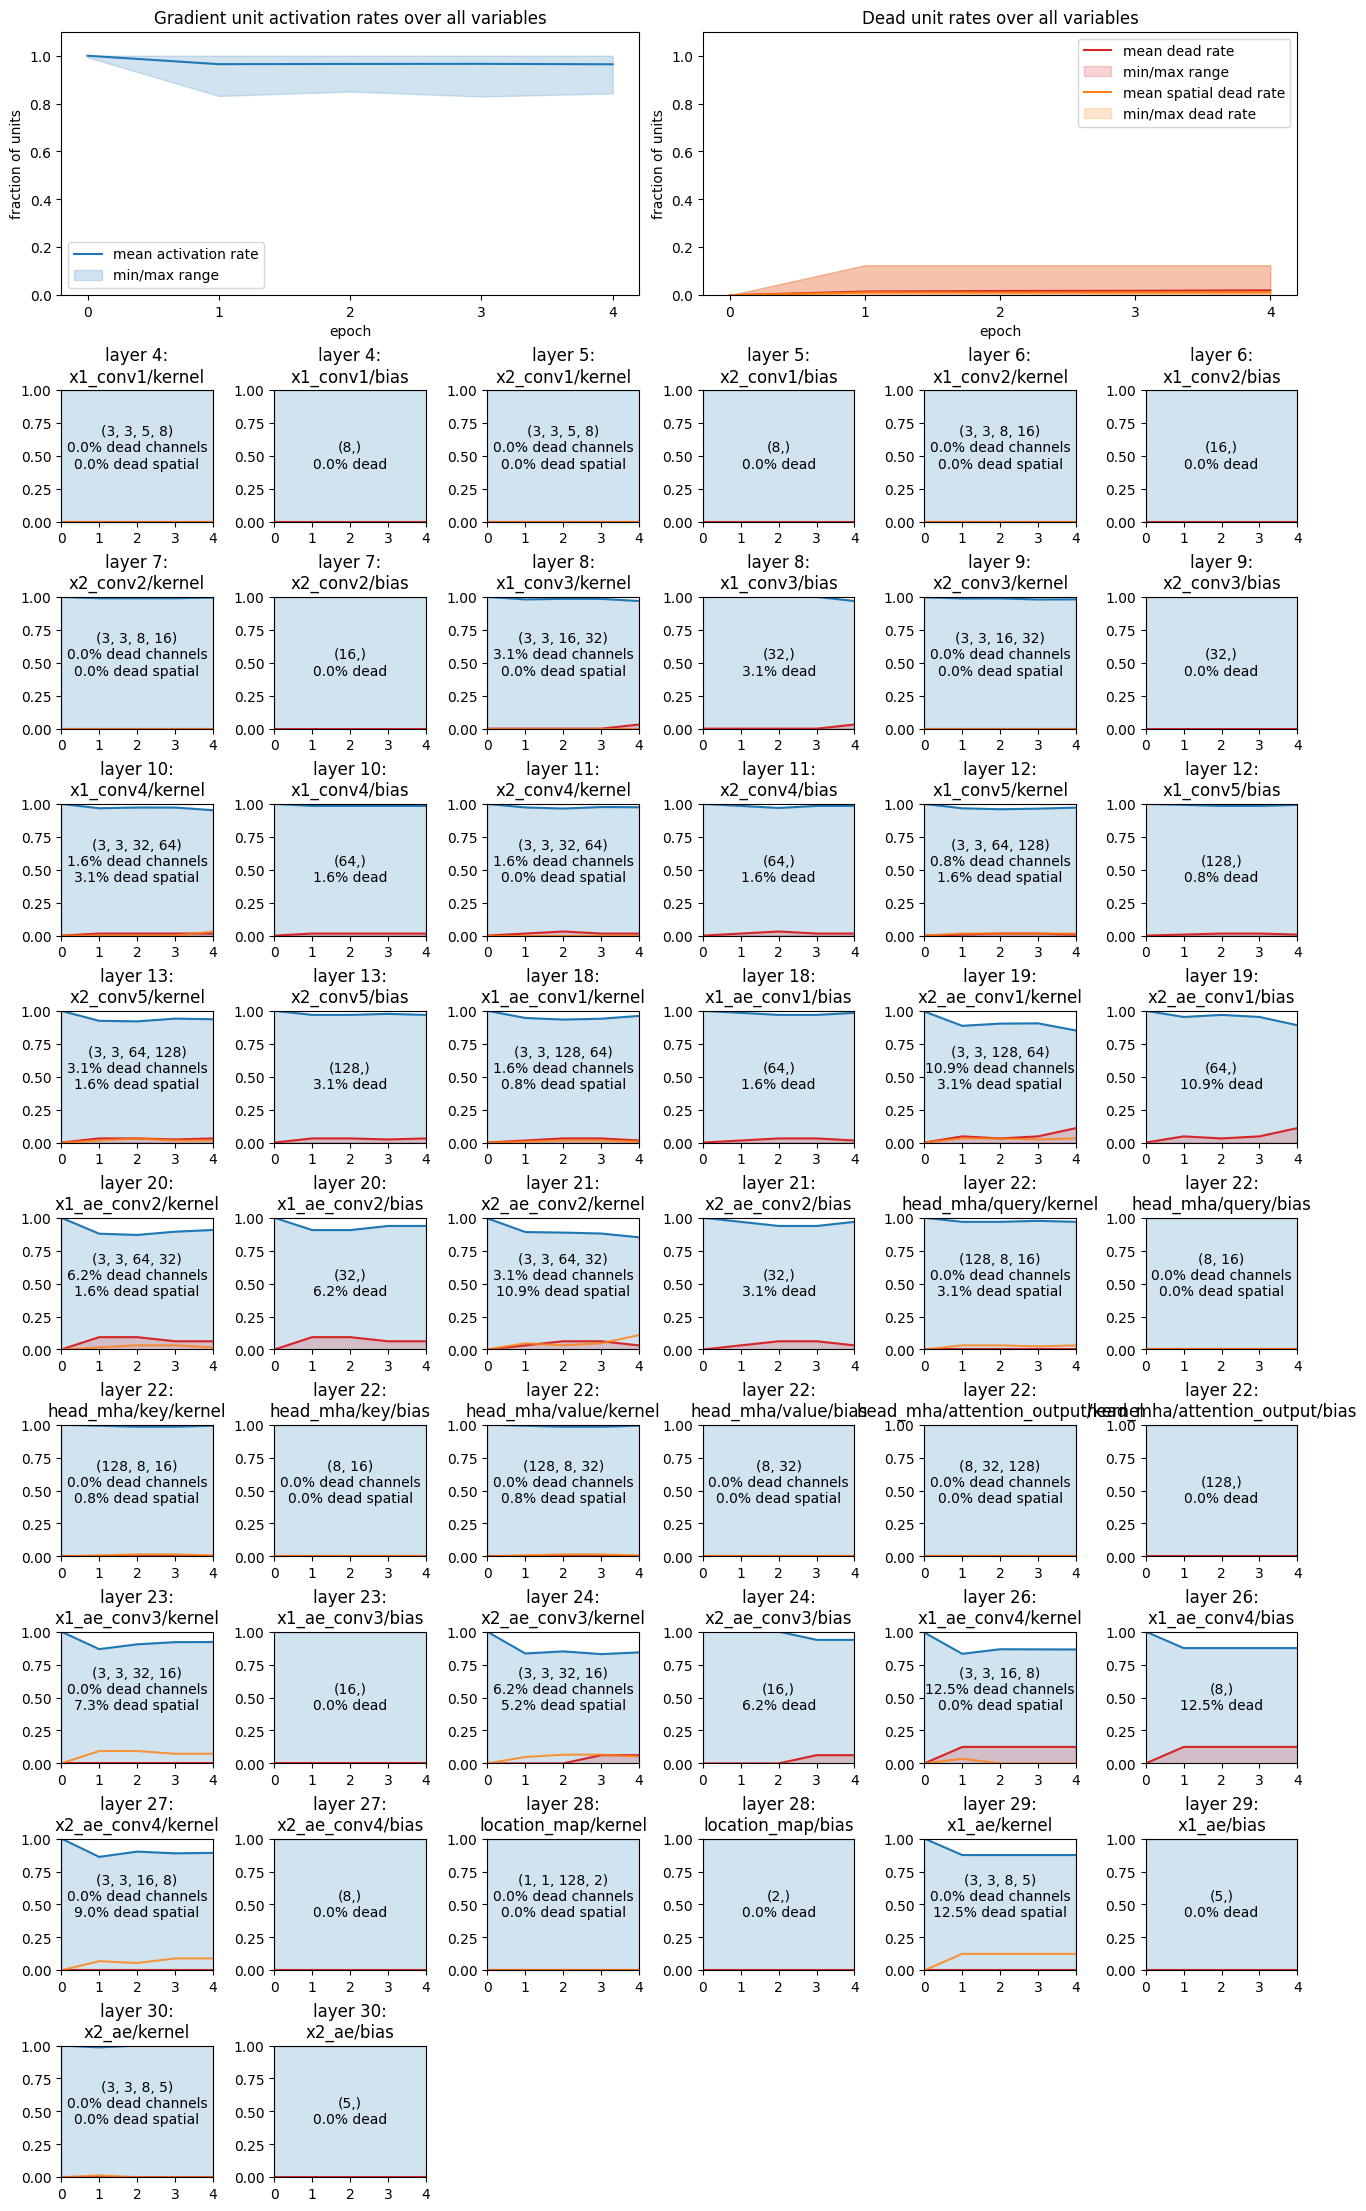

In [28]:
tinstr.plot_activity_history(gradients)

In [29]:
tinstr.plot_activity_history(outputs)

ValueError: Callback collects unsupported item type: None

pred_output: <class 'list'> x 3
Corners of crop image (raw):
    [-0.35770667 -0.324659  ]                -         [ 0.09718949 -0.4377786 ]
    [-0.244587    0.13023716]                -         [0.21030909 0.01711756]
Corners of crop image (pixels):
    [4.5533867 5.6109123]                -         [19.110064  1.991085]
    [ 8.173216 20.16759 ]                -         [22.72989  16.547762]


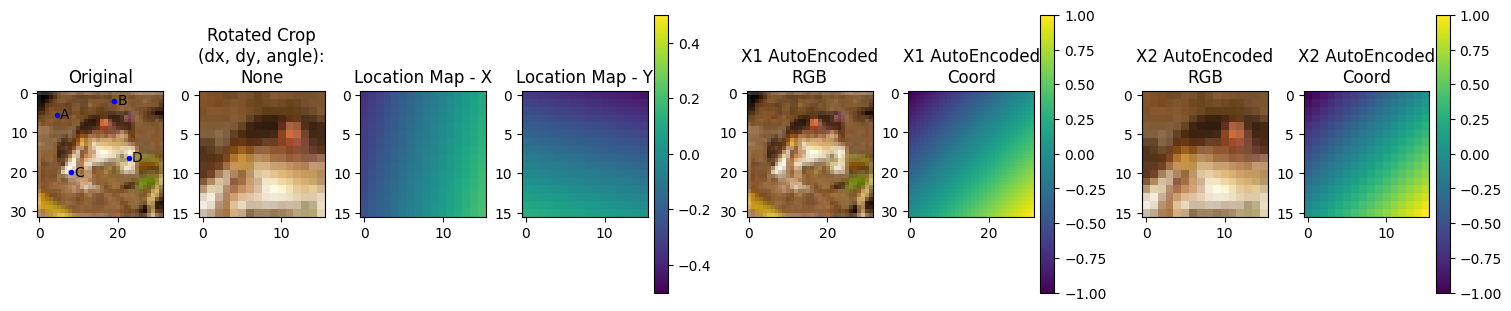

Corners of crop image (raw):
    [-0.01193981 -0.00833368]                -         [-0.01193984 -0.0083336 ]
    [-0.01193984 -0.0083335 ]                -         [-0.01193992 -0.00833357]
Corners of crop image (pixels):
    [15.617926 15.733322]                -         [15.617926 15.733325]
    [15.617926 15.733328]                -         [15.617923 15.733326]


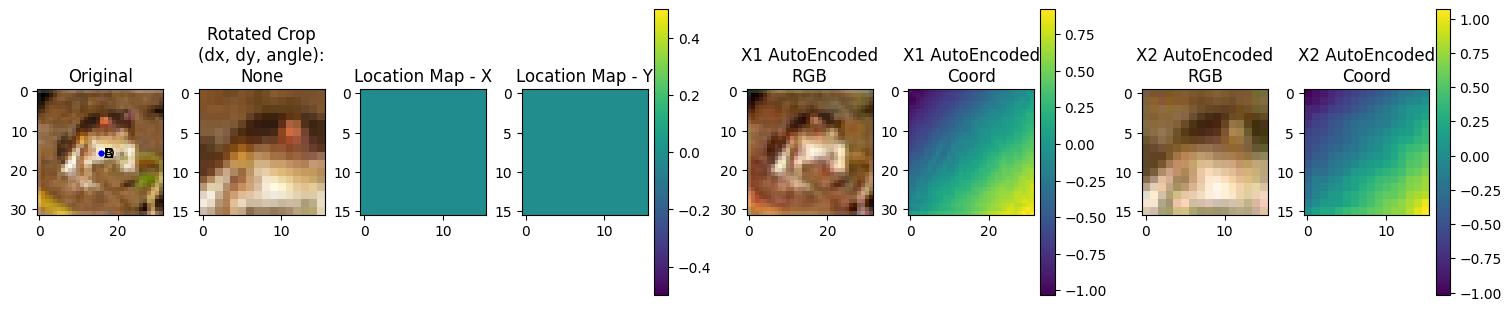

In [30]:
show_model_output_aereg(dataset, model)

outputs: (32, 16, 16, 2)
  [-0.0119398  -0.00833368]  -  [-0.01193983 -0.00833358]
  [-0.01193983 -0.00833354]  -  [-0.01193988 -0.00833361]
outputs: (32, 16, 16, 2)
  [-0.01270556 -0.01015248]  -  [-0.01270553 -0.0101524 ]
  [-0.01270555 -0.01015242]  -  [-0.01270559 -0.01015243]
outputs: (32, 16, 16, 2)
  [-0.01248005 -0.00899827]  -  [-0.01248009 -0.00899819]
  [-0.0124801  -0.00899823]  -  [-0.01248015 -0.00899825]
outputs: (32, 16, 16, 2)
  [-0.01264131 -0.01007987]  -  [-0.01264139 -0.01007992]
  [-0.01264142 -0.01007997]  -  [-0.01264147 -0.01007999]
outputs: (32, 16, 16, 2)
  [-0.01255088 -0.00971317]  -  [-0.01255085 -0.009713  ]
  [-0.01255087 -0.00971311]  -  [-0.01255097 -0.0097131 ]
outputs: (32, 16, 16, 2)
  [-0.01349809 -0.01200402]  -  [-0.01349809 -0.01200357]
  [-0.01349812 -0.01200339]  -  [-0.01349827 -0.01200374]
outputs: (32, 16, 16, 2)
  [-0.01342274 -0.01143553]  -  [-0.01342283 -0.01143537]
  [-0.01342283 -0.01143565]  -  [-0.01342294 -0.01143557]
outputs: (32,

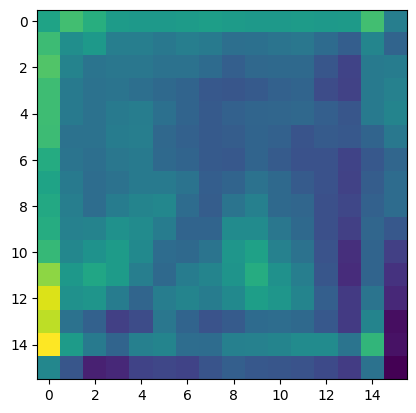

In [32]:
# plot a few predicted examples
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)

for inputs, outputs in dataset.take(10):
    outputs = model(inputs)
    (location_maps, x1_ae, x2_ae) = outputs
    print(f"outputs: {location_maps.shape}")
    print(f"  {location_maps[0, 0, 0, :]}  -  {location_maps[0, 0, -1, :]}")
    print(f"  {location_maps[0, -1, 0, :]}  -  {location_maps[0, -1, -1, :]}")

for inputs, outputs in dataset.take(1):
    outputs = model(inputs)
    (location_maps, x1_ae, x2_ae) = outputs
    plt.imshow(location_maps[0,:,:,0])
    plt.show()


## MHA-only model
There seems to be something fundamentally wrong with my use of the MHA layer itself. So let's create an extreme model, that is basically just an MHA layer.

In [13]:
def mha_only_model():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Reshape((-1, 5), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Reshape((-1, 5), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    x = layers.MultiHeadAttention(num_heads=8, key_dim=16, value_dim=16, output_shape=2, name="head_mha")(
        query=x2, key=x1, value=x1)

    # alternative:
    # x = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mhe")(
    #     query=x2, key=x1, value=x1)

    # Compute per-pixel local translations
    # - reshape back to (height, width, channels)
    # - 256x32 -> 16x16x32 -> 16x16x2
    x = layers.Reshape((16, 16, -1), name='head_reshape')(x)
    #x = layers.Conv2D(filters=2, kernel_size=1, name='location_map')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=[x])

mha_only_model().summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape (Reshape)      │ (None, 1024, 5)        │              0 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape (Reshape)      │ (None, 256, 5)         │              0 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_mha                  │ (None, 256, 2)         │          2,562 │ x1_reshape[0][0],      │
│ (MultiHeadAttention)      │                        │                │ x2_reshape[0][0],      │
│                           │                        │                │ x1_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_reshape (Reshape)    │ (None, 16, 16, 2)      │              0 │ head_mha[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,562 (10.01 KB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# train
model = mha_only_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[tinstr.HistoryStats()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 0.0510
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0285
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0249
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0254
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0248
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0253
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0254
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0252
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0244
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0251


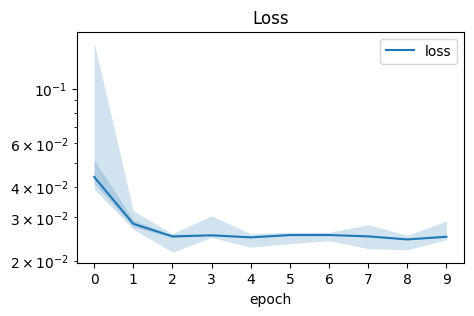

In [15]:
tinstr.plot_train_history(history)

outputs: (32, 16, 16, 2)
  [-0.15049316 -0.1802198 ]  -  [ 0.18639106 -0.1827246 ]
  [-0.14101791  0.11542989]  -  [0.19433789 0.13109255]
outputs: (32, 16, 16, 2)
  [-0.14544882 -0.18851721]  -  [ 0.1971927  -0.20360193]
  [-0.16247188  0.19167265]  -  [0.19101992 0.15535325]
outputs: (32, 16, 16, 2)
  [-0.1545435 -0.1672352]  -  [ 0.18502681 -0.16937724]
  [-0.13534245  0.09755645]  -  [0.19520047 0.11935601]
outputs: (32, 16, 16, 2)
  [-0.15466109 -0.18304259]  -  [ 0.19639233 -0.1389592 ]
  [-0.14650562  0.18226546]  -  [0.19243015 0.17244148]
outputs: (32, 16, 16, 2)
  [-0.21520066 -0.16927382]  -  [ 0.141623  -0.1769906]
  [-0.11484506  0.15784734]  -  [0.13483919 0.13510826]
outputs: (32, 16, 16, 2)
  [-0.15493198 -0.28032967]  -  [ 0.17984371 -0.26832584]
  [-0.14330265  0.1321035 ]  -  [0.18816787 0.08994698]
outputs: (32, 16, 16, 2)
  [-0.14741899 -0.3011404 ]  -  [ 0.18671545 -0.26558265]
  [-0.14844407  0.13405183]  -  [0.1899226 0.2686989]
outputs: (32, 16, 16, 2)
  [-0.15

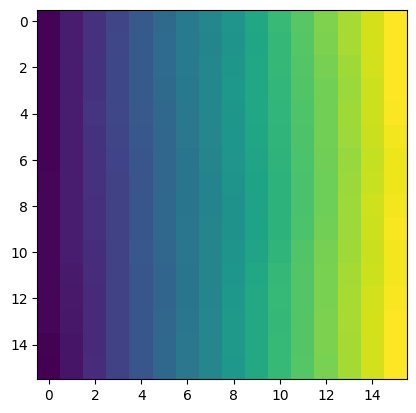

In [16]:
# plot a few predicted examples
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)

for inputs, outputs in dataset.take(10):
    outputs = model(inputs)
    print(f"outputs: {outputs.shape}")
    print(f"  {outputs[0, 0, 0, :]}  -  {outputs[0, 0, -1, :]}")
    print(f"  {outputs[0, -1, 0, :]}  -  {outputs[0, -1, -1, :]}")

for inputs, outputs in dataset.take(1):
    outputs = model(inputs)
    plt.imshow(outputs[0,:,:,0])
    plt.show()

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.30495316 -0.19024149]                -         [ 0.13867545 -0.34163564]
    [-0.15355903  0.25338715]                -         [0.29006964 0.10199296]
Corners of crop image (pixels):
    [6.241499 9.912272]                -         [20.437614   5.0676594]
    [11.086111 24.108389]                -         [25.282228 19.263775]


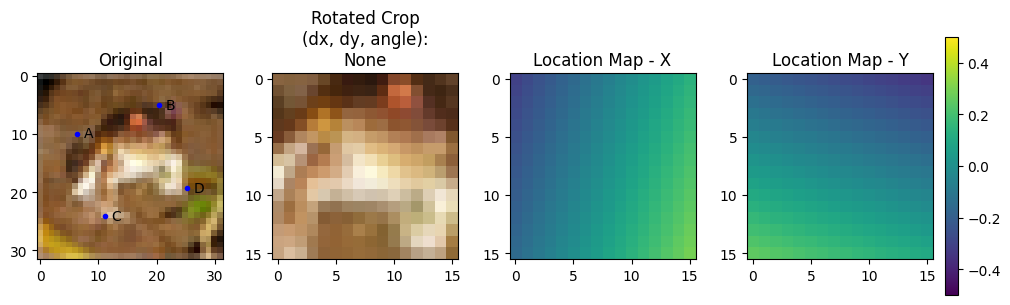

Corners of crop image (raw):
    [-0.15058061 -0.1844779 ]                -         [ 0.1917468  -0.19933218]
    [-0.1529916  0.1494919]                -         [0.19204518 0.13973385]
Corners of crop image (pixels):
    [11.18142  10.096707]                -         [22.135899  9.62137 ]
    [11.104269 20.783741]                -         [22.145447 20.471483]


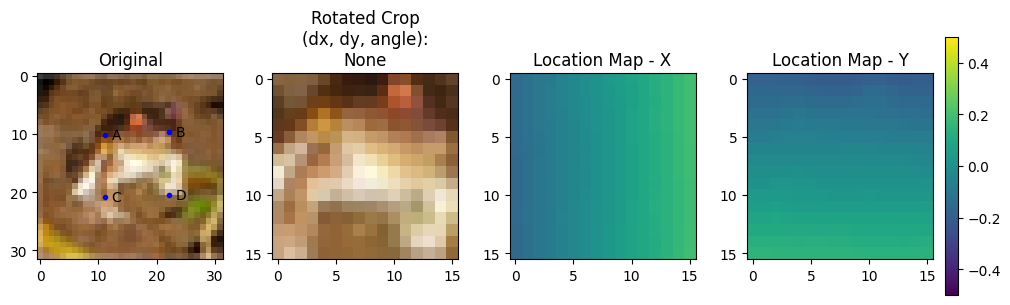

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [ 0.10688198 -0.50296587]                -         [ 0.38548803 -0.12599733]
    [-0.27008653 -0.22435981]                -         [0.00851953 0.15260863]
Corners of crop image (pixels):
    [19.420223   -0.09490776]                -         [28.335617 11.968085]
    [7.357231 8.820486]                -         [16.272625 20.883476]


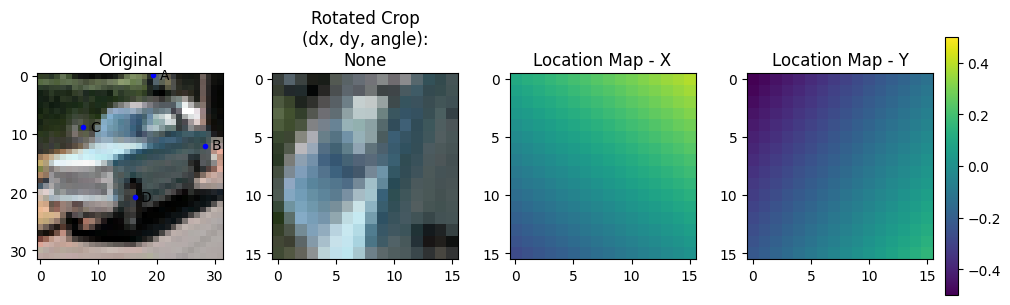

Corners of crop image (raw):
    [-0.14290202 -0.19816911]                -         [ 0.19759694 -0.20479834]
    [-0.14306165  0.14878786]                -         [0.20121656 0.134606  ]
Corners of crop image (pixels):
    [11.427135  9.658588]                -         [22.323101  9.446453]
    [11.422028 20.761211]                -         [22.43893  20.307392]


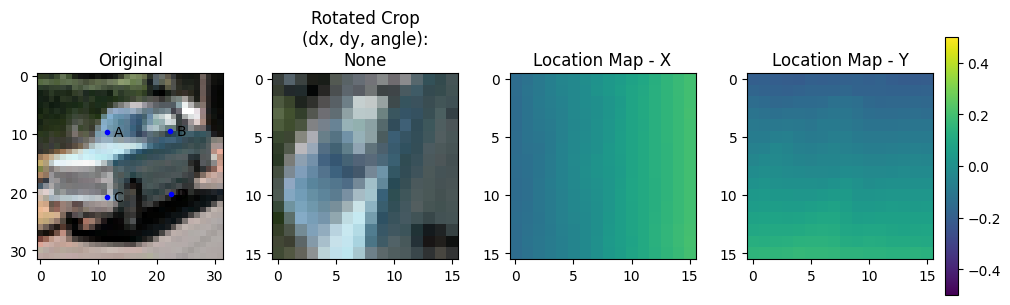

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.23649418 -0.30278513]                -         [ 0.23006266 -0.34807622]
    [-0.19120309  0.16377175]                -         [0.27535373 0.11848062]
Corners of crop image (pixels):
    [8.432186 6.310876]                -         [23.362005  4.861561]
    [ 9.881501 21.240696]                -         [24.81132 19.79138]


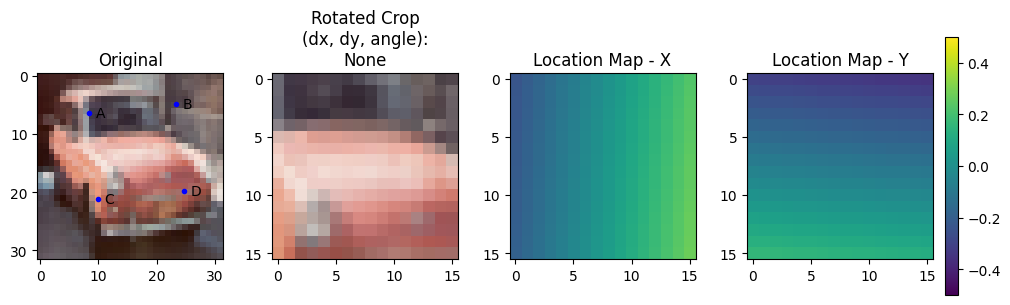

Corners of crop image (raw):
    [-0.1511251  -0.18345797]                -         [ 0.18364747 -0.16601202]
    [-0.14388333  0.13884392]                -         [0.19235978 0.13673258]
Corners of crop image (pixels):
    [11.163997 10.129345]                -         [21.876719 10.687615]
    [11.395733 20.443005]                -         [22.155514 20.375443]


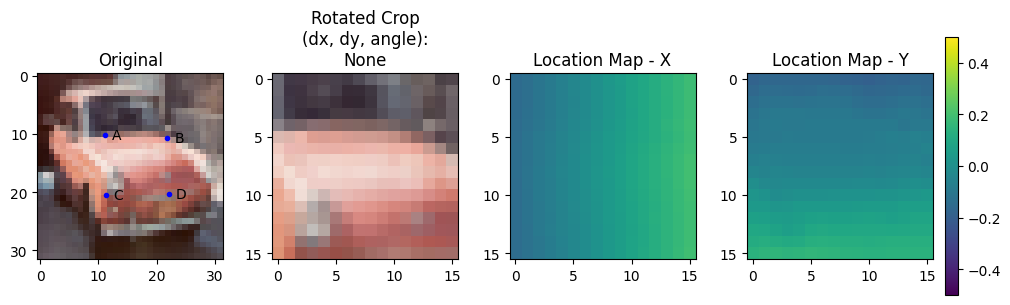

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.07663995 -0.31108254]                -         [ 0.36538064 -0.15505564]
    [-0.23266685  0.13093805]                -         [0.20935369 0.2869649 ]
Corners of crop image (pixels):
    [13.547522   6.0453587]                -         [27.69218  11.038219]
    [ 8.554661 20.190018]                -         [22.699318 25.182877]


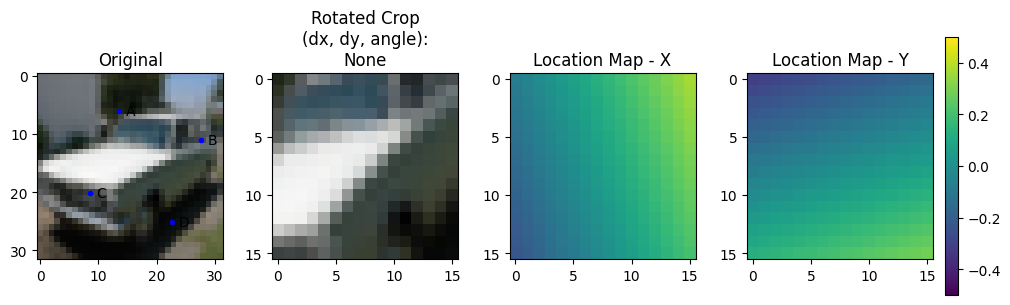

Corners of crop image (raw):
    [-0.14425996 -0.13712552]                -         [ 0.19086552 -0.16146669]
    [-0.14959244  0.16623718]                -         [0.19833411 0.19795683]
Corners of crop image (pixels):
    [11.383681 11.611983]                -         [22.107697 10.833066]
    [11.213041 21.31959 ]                -         [22.346691 22.334618]


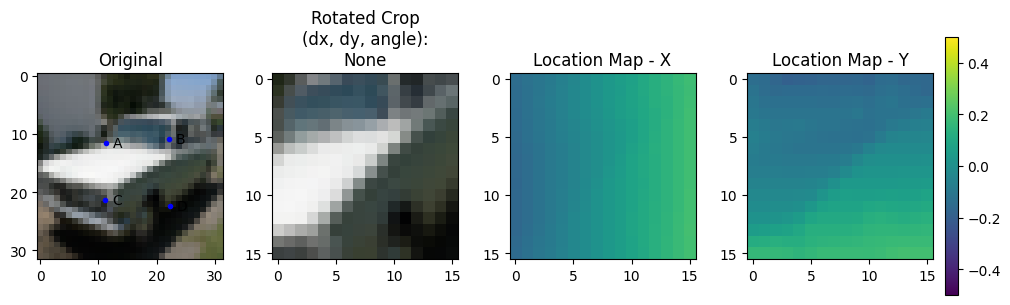

outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
outputs: <class 'tensorflow.python.framework.ops.EagerTensor'> x 32
Corners of crop image (raw):
    [-0.48008588 -0.01986673]                -         [-0.06279212 -0.23339075]
    [-0.26656187  0.39742702]                -         [0.15073186 0.18390298]
Corners of crop image (pixels):
    [ 0.63725185 15.3642645 ]                -         [13.990652  8.531496]
    [ 7.4700203 28.717665 ]                -         [20.82342  21.884895]


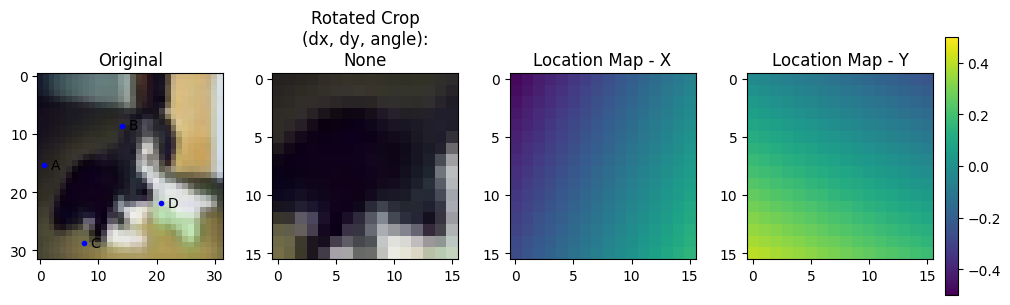

Corners of crop image (raw):
    [-0.20199993 -0.1659224 ]                -         [ 0.14454411 -0.17872757]
    [-0.13958564  0.15115133]                -         [0.25934532 0.12907618]
Corners of crop image (pixels):
    [ 9.536002 10.690483]                -         [20.625412 10.280718]
    [11.533259 20.836842]                -         [24.29905  20.130438]


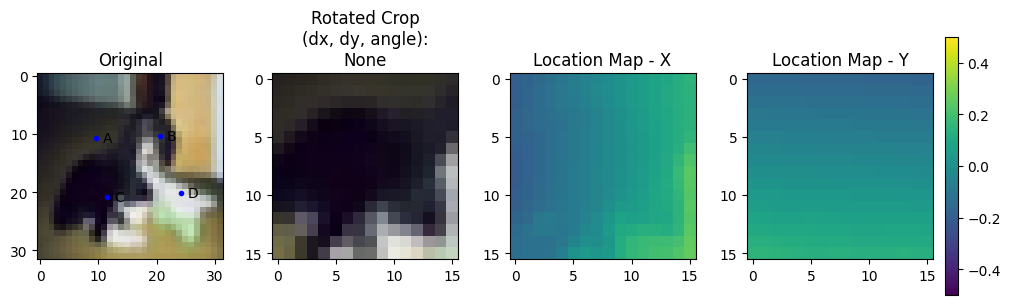

In [33]:
show_model_output(dataset, model, 5)

**Instrumented training**

In [34]:
variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = mha_only_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0366


Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0268
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0255
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0251
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0257
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0248
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0246
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0253
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 0.0251
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 0.0251


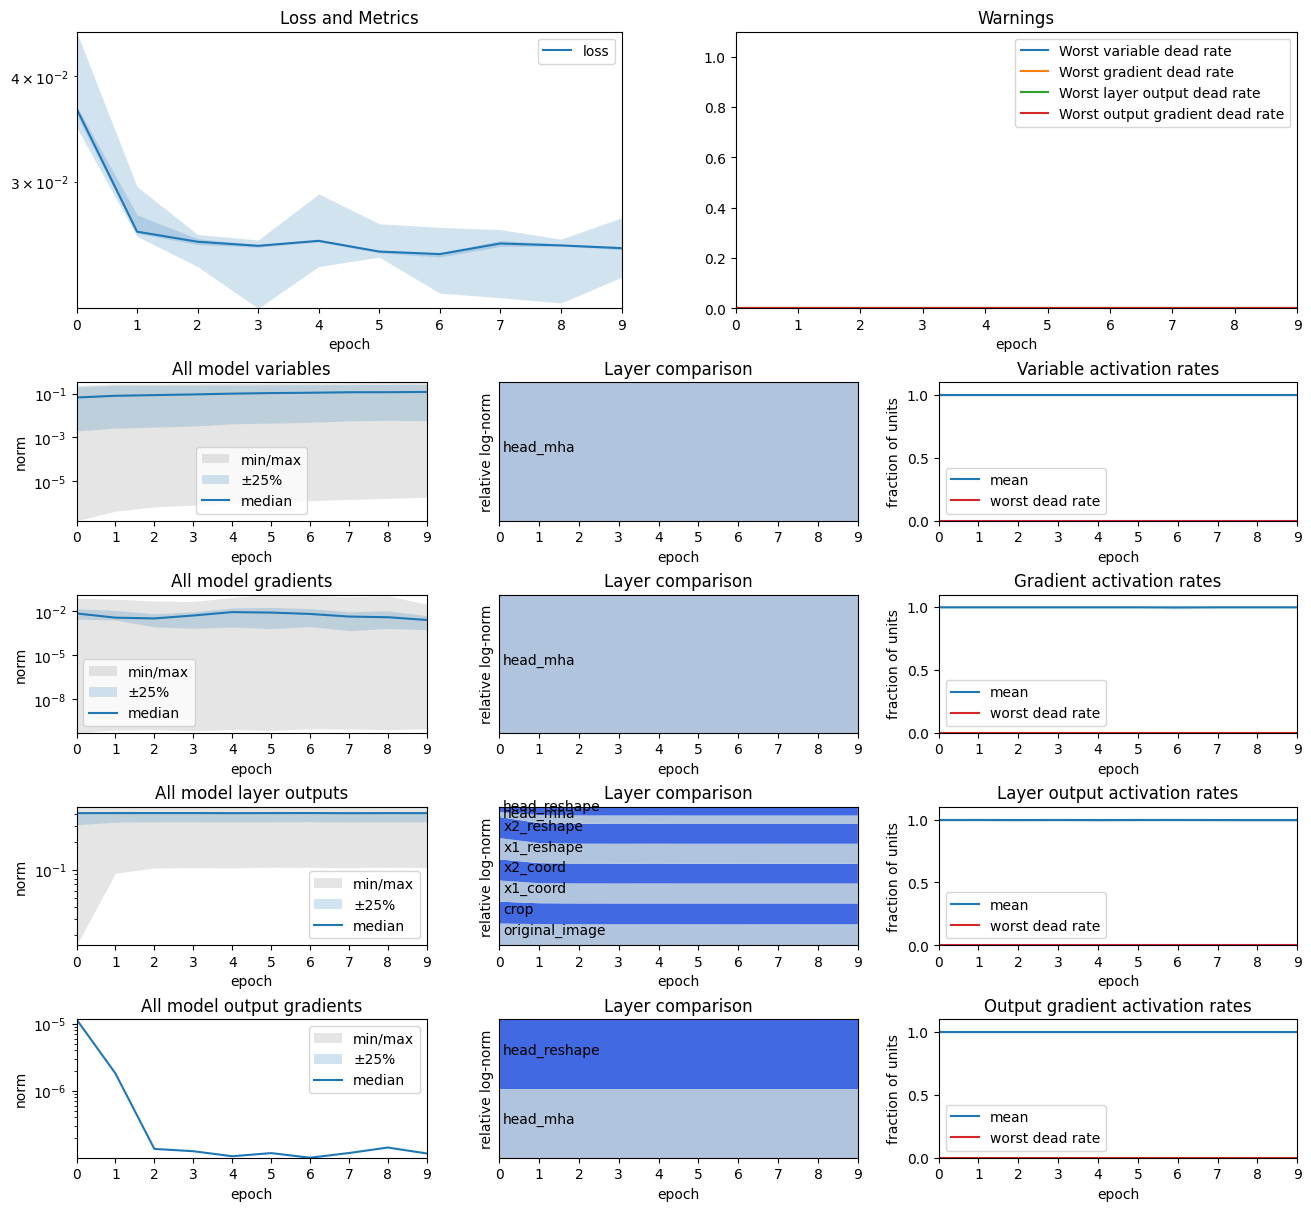

In [35]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

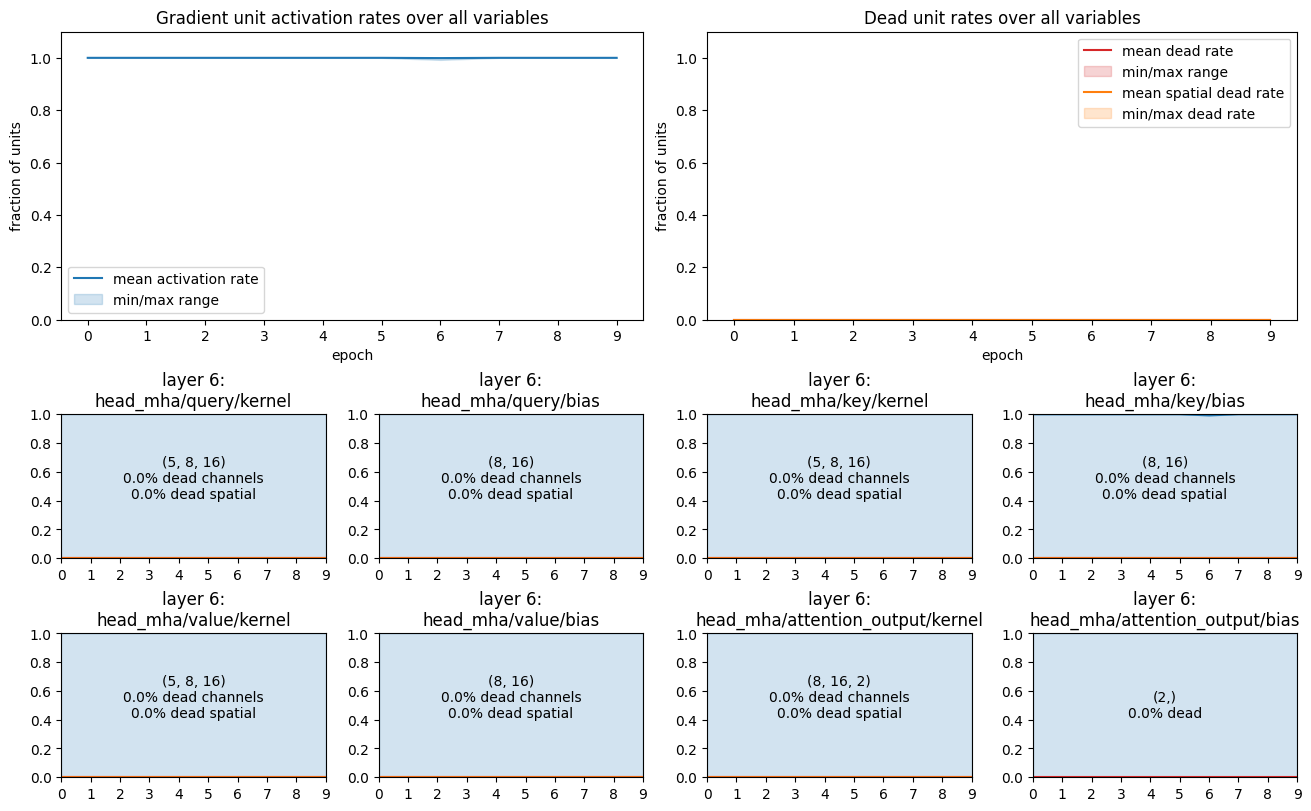

In [36]:
tinstr.plot_activity_history(gradients)

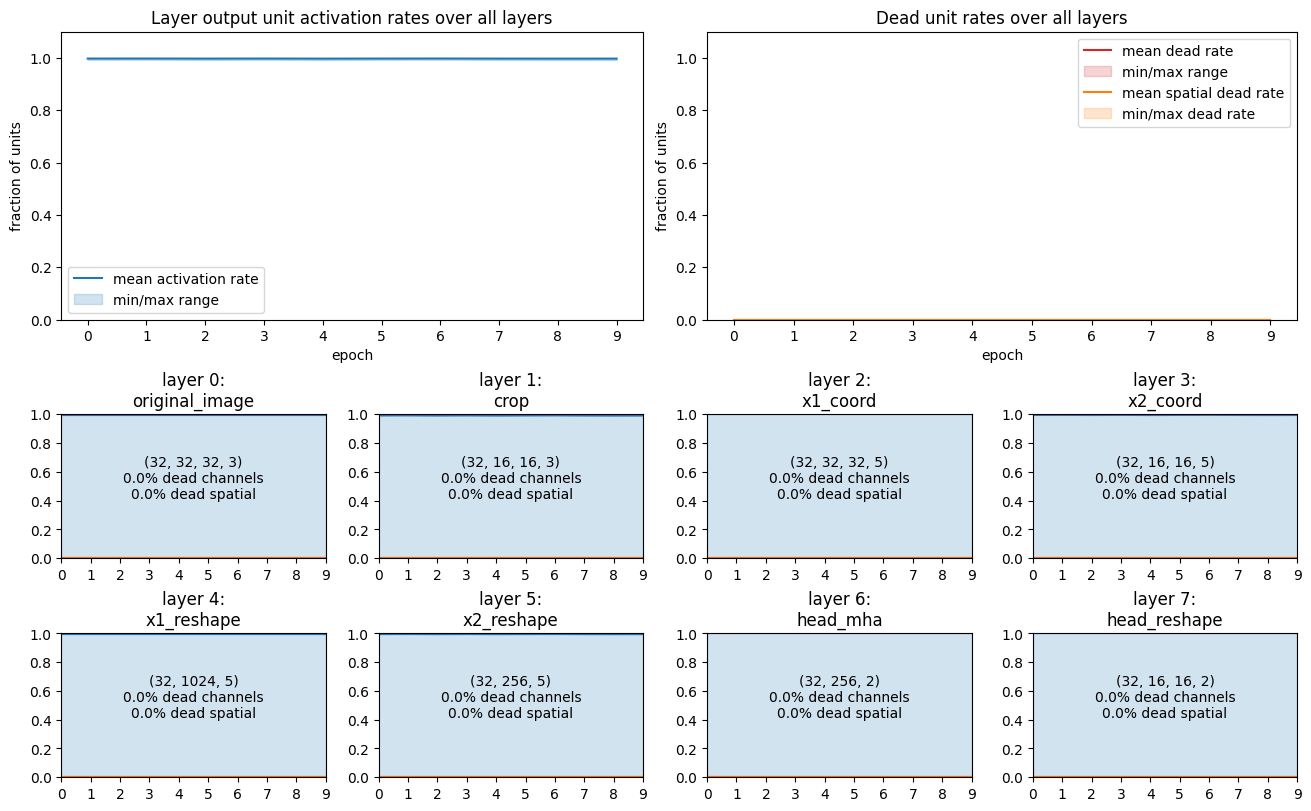

In [37]:
tinstr.plot_activity_history(outputs)

**MHA-only with a little more capacity**

In [38]:
def mha_only_model2():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Reshape((32*32, -1), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Reshape((16*16, -1), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    x = layers.MultiHeadAttention(num_heads=8, key_dim=16, value_dim=16, name="head_mha")(
        query=x2, key=x1, value=x1)

    # alternative:
    # x = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mhe")(
    #     query=x2, key=x1, value=x1)

    # Compute per-pixel local translations
    # - reshape back to (height, width, channels)
    # - 256x32 -> 16x16x32 -> 16x16x2
    x = layers.Reshape((16, 16, -1), name='head_reshape')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='location_map')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=[x])

mha_only_model2().summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape (Reshape)      │ (None, 1024, 8)        │              0 │ x1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape (Reshape)      │ (None, 256, 8)         │              0 │ x2_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_mha                  │ (None, 256, 8)         │          4,488 │ x1_reshape[0][0],      │
│ (MultiHeadAttention)      │                        │                │ x2_reshape[0][0],      │
│                           │                        │                │ x1_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_reshape (Reshape)    │ (None, 16, 16, 8)      │              0 │ head_mha[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ location_map (Conv2D)     │ (None, 16, 16, 2)      │             18 │ head_reshape[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,242 (20.48 KB)

 Trainable params: 5,242 (20.48 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = mha_only_model2()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 0.0368


Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0263
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0258
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0257
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0260
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0253
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0254
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0260
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0247
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0255


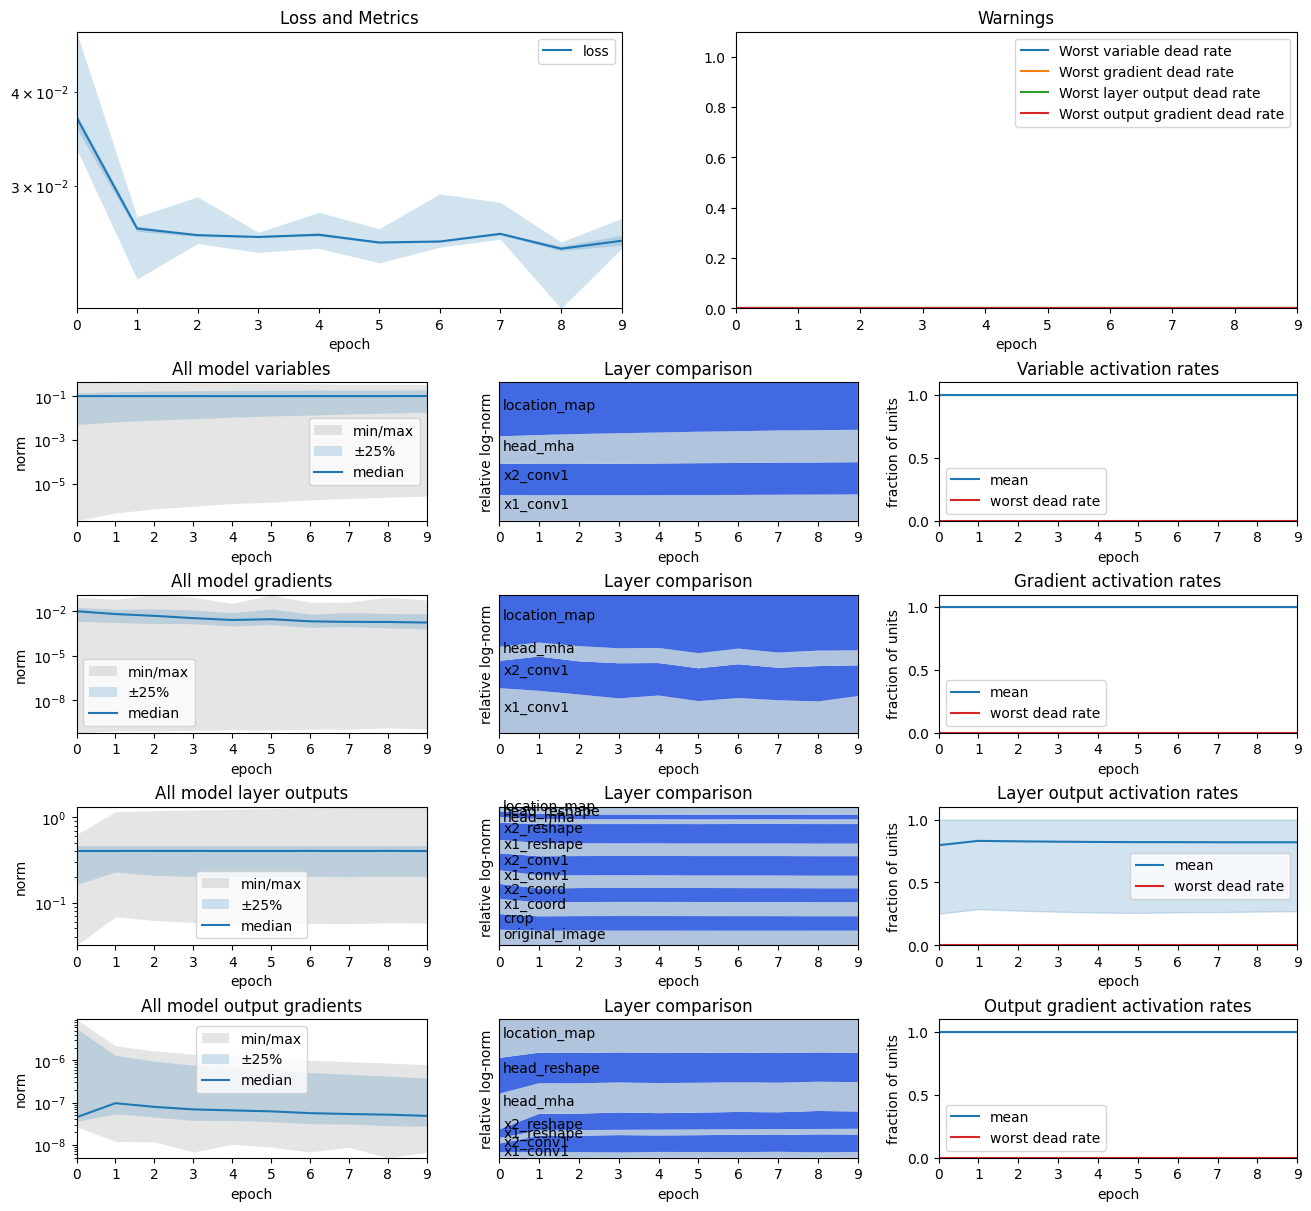

In [41]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

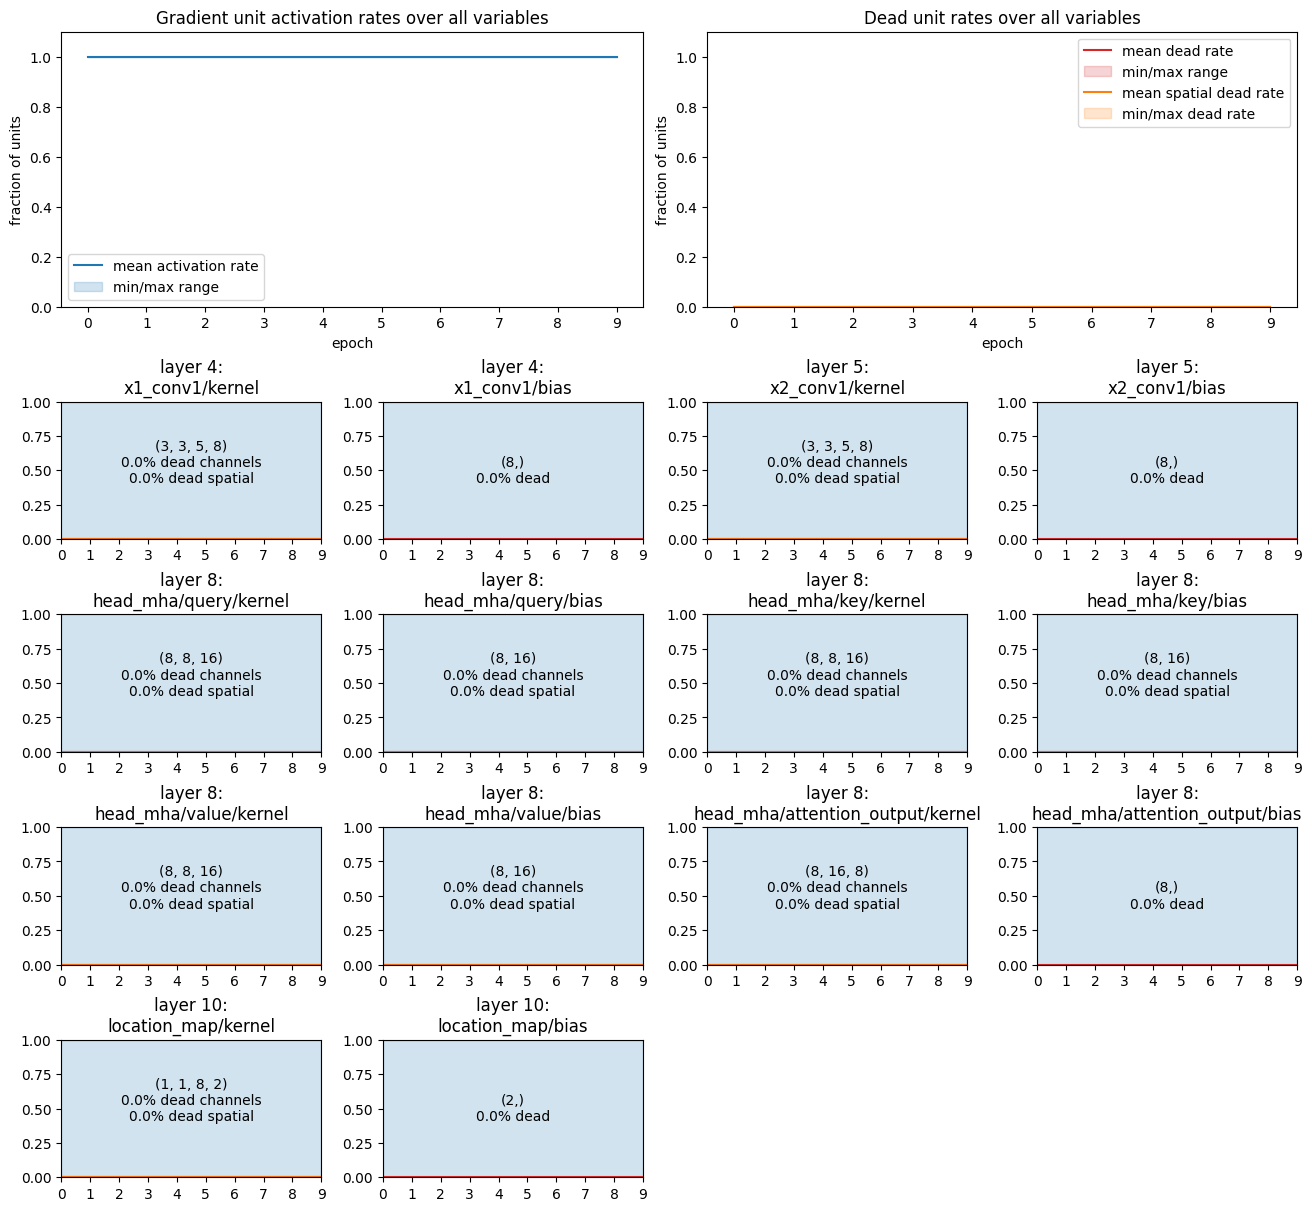

In [42]:
tinstr.plot_activity_history(gradients)

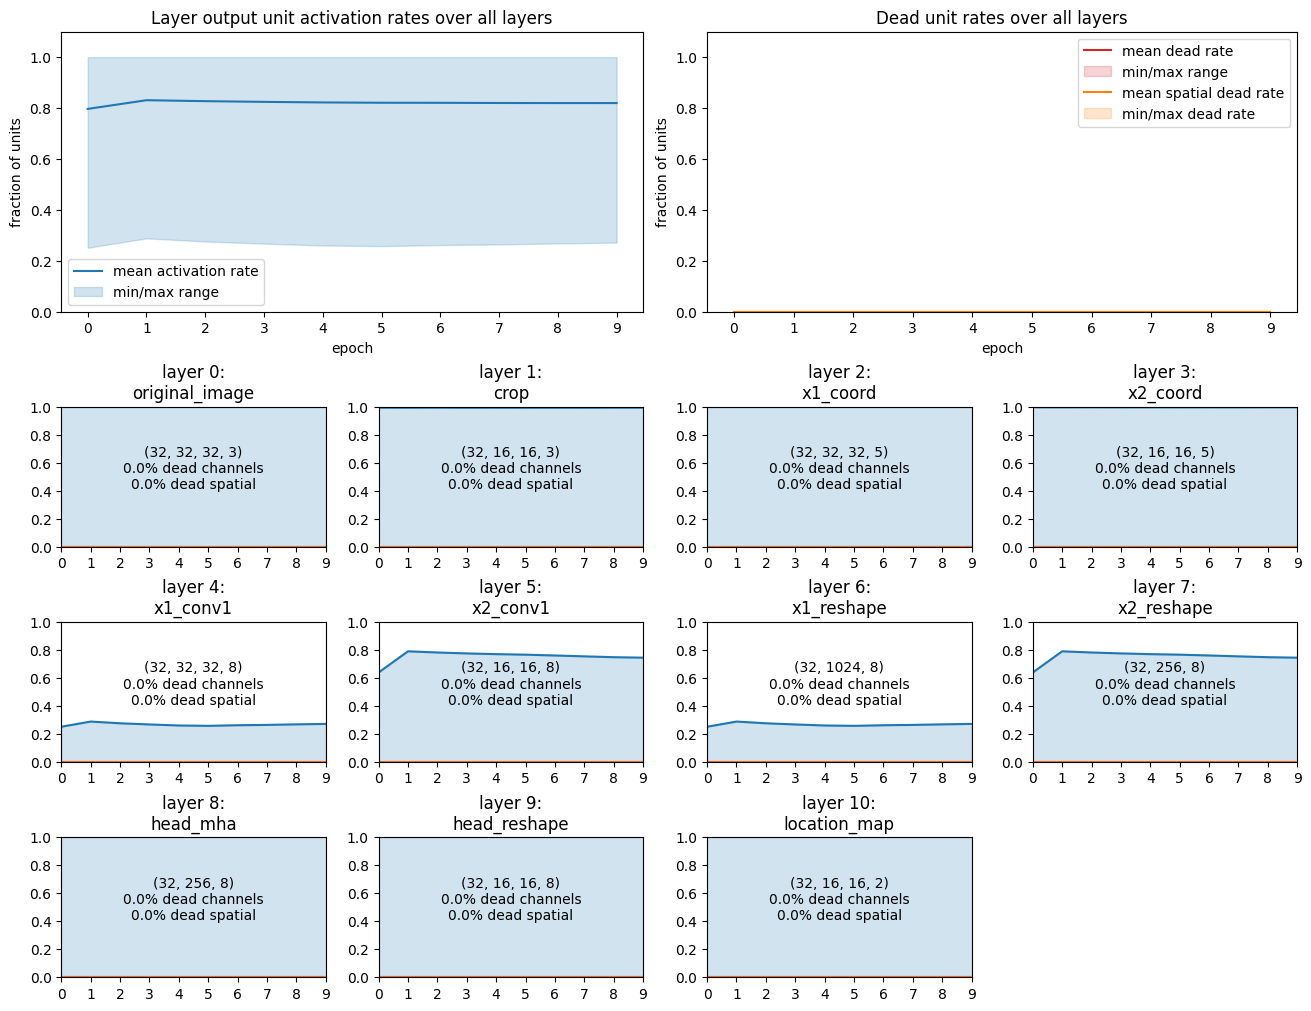

In [43]:
tinstr.plot_activity_history(outputs)

**New theory**

Even with 1 conv layer on the input arm, we're starting to get rapid reductions in activity rates. MHA is appears to be functioning correctly, and yet it's applying a strong negative pressure against the channels of its inputs.

I think the problem lies in the sigmoid-attention at the MHA core. It means that an otherwise succesful output is attenuated by the presence of all the other inputs. Gradient descent tries to find the fastest way out of that problem. Which is fastest?:

1. improve all the feature identifiers so that they are more discriminative, and subsequently so that there's more contrast across the sigmoid, while also ensuring that the correct matches get highest scores.

2. Reduce the problematic inputs to zero.

In this view, it's obvious why MHA leads to layer outputs being pushed towards zero.

According to ChatGPT, this basic idea has been reported elsewhere:
* **Vision Transformers (ViTs):** Attention layers sometimes converge to degenerate solutions where value elements get dampened rather than the attention weights improving.
* **Sparse Attention:** Researchers have observed that attention layers naturally push "unimportant" values towards zero.
* **Token Pruning & Feature Collapse:** Some papers (especially in NLP) have discussed “collapse” of feature representations, where attention layers learn to suppress features rather than refining attention.

**Solutions**

Regularization:

* One possible regularization is to directly encourage it to focus on the sigmoid contrast, rather than the values it's sigmoid-scaling. By having the model output the max(attn_coefficients, axis=in_channels) and applying a loss against that.

* ChatGPT suggests normalization just before passing as inputs to the MHA layer.

**With normalization on input layers**

Also, while developing this I initially used the default TF BatchNormalization settings. But I noticed that the activity rates on the conv layer were not 100% and yet the BN layer activity rates was 100%. This didn't make sense until I realised than BN comes out of the box with "center" normalization as well as mean. That's totally pointless after a ReLU layer. So make sure to turn that off.

In [52]:
def mha_only_model3():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.BatchNormalization(center=False)(x1)
    x1 = layers.Reshape((32*32, -1), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.BatchNormalization(center=False)(x2)
    x2 = layers.Reshape((16*16, -1), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    x = layers.MultiHeadAttention(num_heads=8, key_dim=16, value_dim=16, name="head_mha")(
        query=x2, key=x1, value=x1)

    # alternative:
    # x = CrossAttention(num_heads=8, key_dim=16, value_dim=32, name="head_mhe")(
    #     query=x2, key=x1, value=x1)

    # Compute per-pixel local translations
    # - reshape back to (height, width, channels)
    # - 256x32 -> 16x16x32 -> 16x16x2
    x = layers.Reshape((16, 16, -1), name='head_reshape')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='location_map')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=[x])

mha_only_model3().summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 32, 32, 8)      │             24 │ x1_conv1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 16, 16, 8)      │             24 │ x2_conv1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape (Reshape)      │ (None, 1024, 8)        │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape (Reshape)      │ (None, 256, 8)         │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_mha                  │ (None, 256, 8)         │          4,488 │ x1_reshape[0][0],      │
│ (MultiHeadAttention)      │                        │                │ x2_reshape[0][0],      │
│                           │                        │                │ x1_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_reshape (Reshape)    │ (None, 16, 16, 8)      │              0 │ head_mha[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ location_map (Conv2D)     │ (None, 16, 16, 2)      │             18 │ head_reshape[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,290 (20.66 KB)

 Trainable params: 5,258 (20.54 KB)

 Non-trainable params: 32 (128.00 B)

In [59]:
[v.path for v in model.variables]

['x1_conv1/kernel',
 'x1_conv1/bias',
 'x2_conv1/kernel',
 'x2_conv1/bias',
 'batch_normalization_10/gamma',
 'batch_normalization_10/moving_mean',
 'batch_normalization_10/moving_variance',
 'batch_normalization_11/gamma',
 'batch_normalization_11/moving_mean',
 'batch_normalization_11/moving_variance',
 'head_mha/query/kernel',
 'head_mha/query/bias',
 'head_mha/key/kernel',
 'head_mha/key/bias',
 'head_mha/value/kernel',
 'head_mha/value/bias',
 'head_mha/attention_output/kernel',
 'head_mha/attention_output/bias',
 'location_map/kernel',
 'location_map/bias']

In [60]:
variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = mha_only_model3()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0314
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0255
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0249
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0245
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0250
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0245
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0249
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0242
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0242
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0243


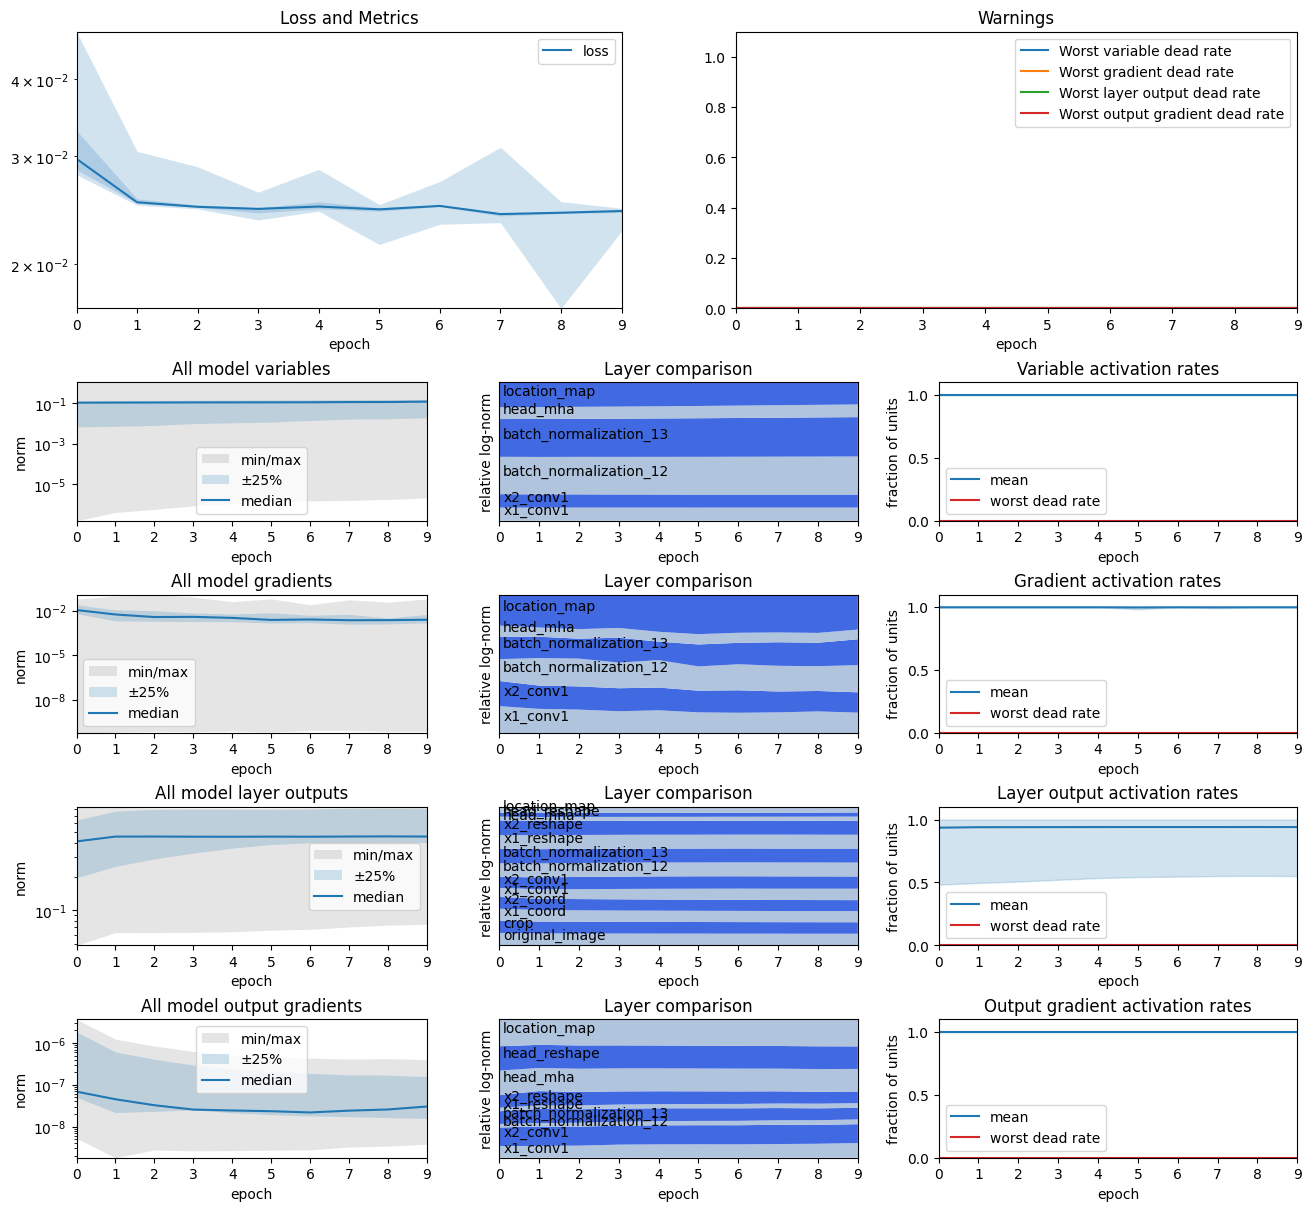

In [61]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

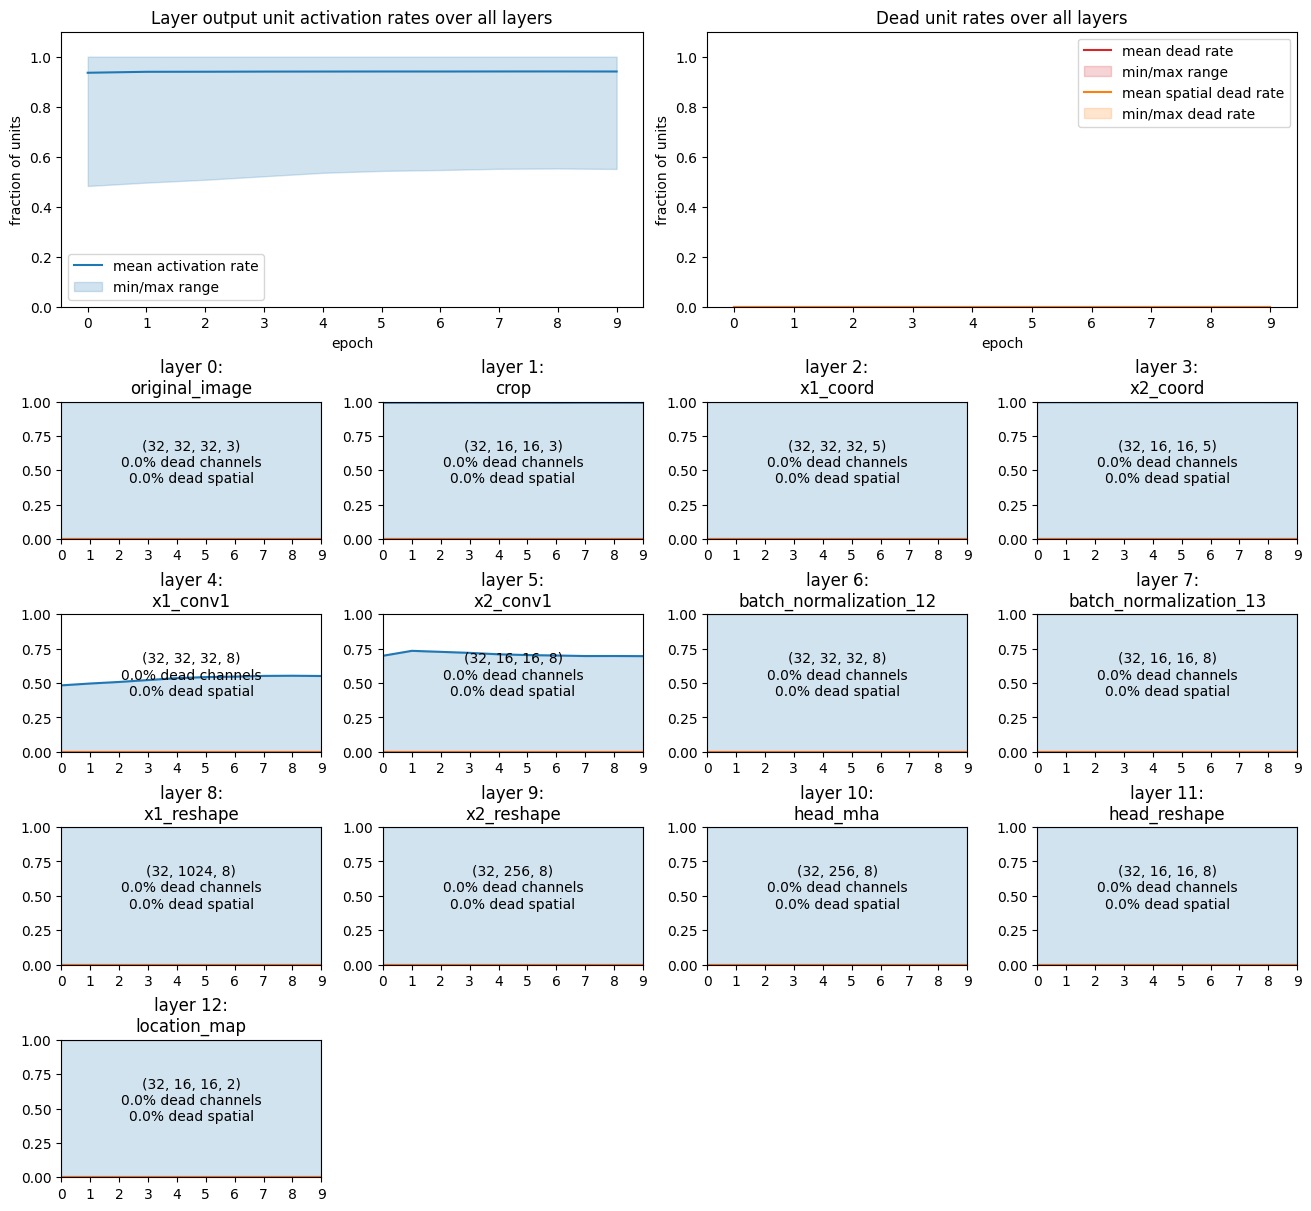

In [62]:
tinstr.plot_activity_history(outputs)

In [49]:
# long train
model = mha_only_model3()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=[]
)
dataset = prepared_dataset('location_map').take(6000).batch(32).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=50, callbacks=[tinstr.HistoryStats()])

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - loss: 0.0292
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0257
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.0257
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0259
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0257
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0250
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0244
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0245
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0247
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0244
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0247
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0242
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0240
Epoch 14/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0244
Epoch 15/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 

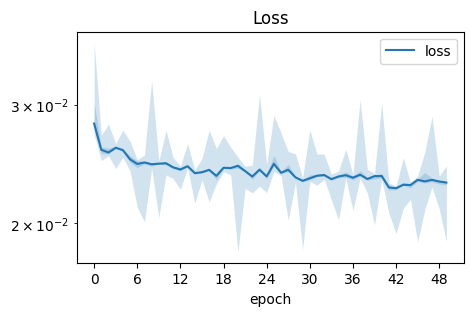

In [50]:
tinstr.plot_train_history(history)

**Normalizing attention coefficients**

In [84]:
class MaxAttnLoss(tf.keras.losses.Loss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def call(self, y_true, y_pred):
        # y_pred: shape = (batch_size, heads, out_channels, in_channels)
        loss = 1.0 - tf.reduce_max(y_pred, axis=-1)
        return tf.reduce_mean(loss, axis=(1,2))

def mha_only_model4():
    original_input = tf.keras.Input(shape=(32, 32, 3), name="original_image")
    crop_input = tf.keras.Input(shape=(16, 16, 3), name="crop")

    # A CNN stack for the 32x32 original image
    x1 = CoordConv(name='x1_coord')(original_input)
    x1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x1_conv1')(x1)
    x1 = layers.Reshape((32*32, -1), name='x1_reshape')(x1)

    # Separate CNN stack for the 16x16 cropped input
    x2 = CoordConv(name='x2_coord')(crop_input)
    x2 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', name='x2_conv1')(x2)
    x2 = layers.Reshape((16*16, -1), name='x2_reshape')(x2)

    # Cross-attention
    #   - query/key = nominally, feature descriptors on x2 and x1, respectively
    #   - value     = nominally, spatial descriptor from x1
    #   - result    = nominally, each pixel in x2 now holds the spatial-descriptor of its original location in x1
    # NOTE: layers.MultiHeadAttention() still fails to return the correct shape (returns (None, 8, 256, 256) instead of (None, 8, 256, 1024))
    #x, x_attn = layers.MultiHeadAttention(num_heads=8, key_dim=16, value_dim=16, name="head_mha")(
    #    query=x2, key=x1, value=x1, return_attention_scores=True)

    # alternative:
    x, x_attn = CrossAttention(num_heads=8, key_dim=16, value_dim=32, return_attention_scores=True, name="head_mha")(
        query=x2, key=x1, value=x1)

    # Compute per-pixel local translations
    # - reshape back to (height, width, channels)
    # - 256x32 -> 16x16x32 -> 16x16x2
    x = layers.Reshape((16, 16, -1), name='head_reshape')(x)
    x = layers.Conv2D(filters=2, kernel_size=1, name='location_map')(x)

    return tf.keras.Model(inputs=[original_input, crop_input], outputs=[x, x_attn])

# dataset map function
def ds_with_attn(inputs, outputs):
  location_map = outputs
  return inputs, (location_map, tf.constant(1.0))

mha_only_model4().summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ original_image            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop (InputLayer)         │ (None, 16, 16, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_coord (CoordConv)      │ (None, 32, 32, 5)      │              0 │ original_image[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_coord (CoordConv)      │ (None, 16, 16, 5)      │              0 │ crop[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_conv1 (Conv2D)         │ (None, 32, 32, 8)      │            368 │ x1_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_conv1 (Conv2D)         │ (None, 16, 16, 8)      │            368 │ x2_coord[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x1_reshape (Reshape)      │ (None, 1024, 8)        │              0 │ x1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x2_reshape (Reshape)      │ (None, 256, 8)         │              0 │ x2_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_mha (CrossAttention) │ [(None, 256, 32),      │         12,288 │ x1_reshape[0][0],      │
│                           │ (None, 8, 256, 1024)]  │                │ x2_reshape[0][0],      │
│                           │                        │                │ x1_reshape[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ head_reshape (Reshape)    │ (None, 16, 16, 32)     │              0 │ head_mha[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ location_map (Conv2D)     │ (None, 16, 16, 2)      │             66 │ head_reshape[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,090 (51.13 KB)

 Trainable params: 13,090 (51.13 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# train
reload(tinstr)

variables = tinstr.VariableHistoryCallback()
gradients = tinstr.GradientHistoryCallback()
outputs = tinstr.LayerOutputHistoryCallback()
output_gradients = tinstr.LayerOutputGradientHistoryCallback()

model = mha_only_model4()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        'location_map': 'mse',
        'head_mha': MaxAttnLoss(),
    }
)
dataset = prepared_dataset('location_map').take(6000).batch(32).map(ds_with_attn).prefetch(tf.data.AUTOTUNE)
history = tinstr.fit(model, dataset, epochs=10, callbacks=[variables, gradients, outputs, output_gradients, tinstr.HistoryStats()])

Epoch 1/10
  1/188 ━━━━━━━━━━━━━━━━━━━━ 8:36 3s/step - head_mha_loss: 0.9990 - location_map_loss: 0.0461 - loss: 1.0452activations: 11
  types: [<class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>, <class 'tensorflow.python.framework.ops.EagerTensor'>]
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - head_mha_loss: 0.9870 - location_map_loss: 0.0367 - loss: 1.0237
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - head_mha_loss: 0.1704 - location_map_loss: 0.0385 - loss: 0.2089
Epoch 3/10
188/188 

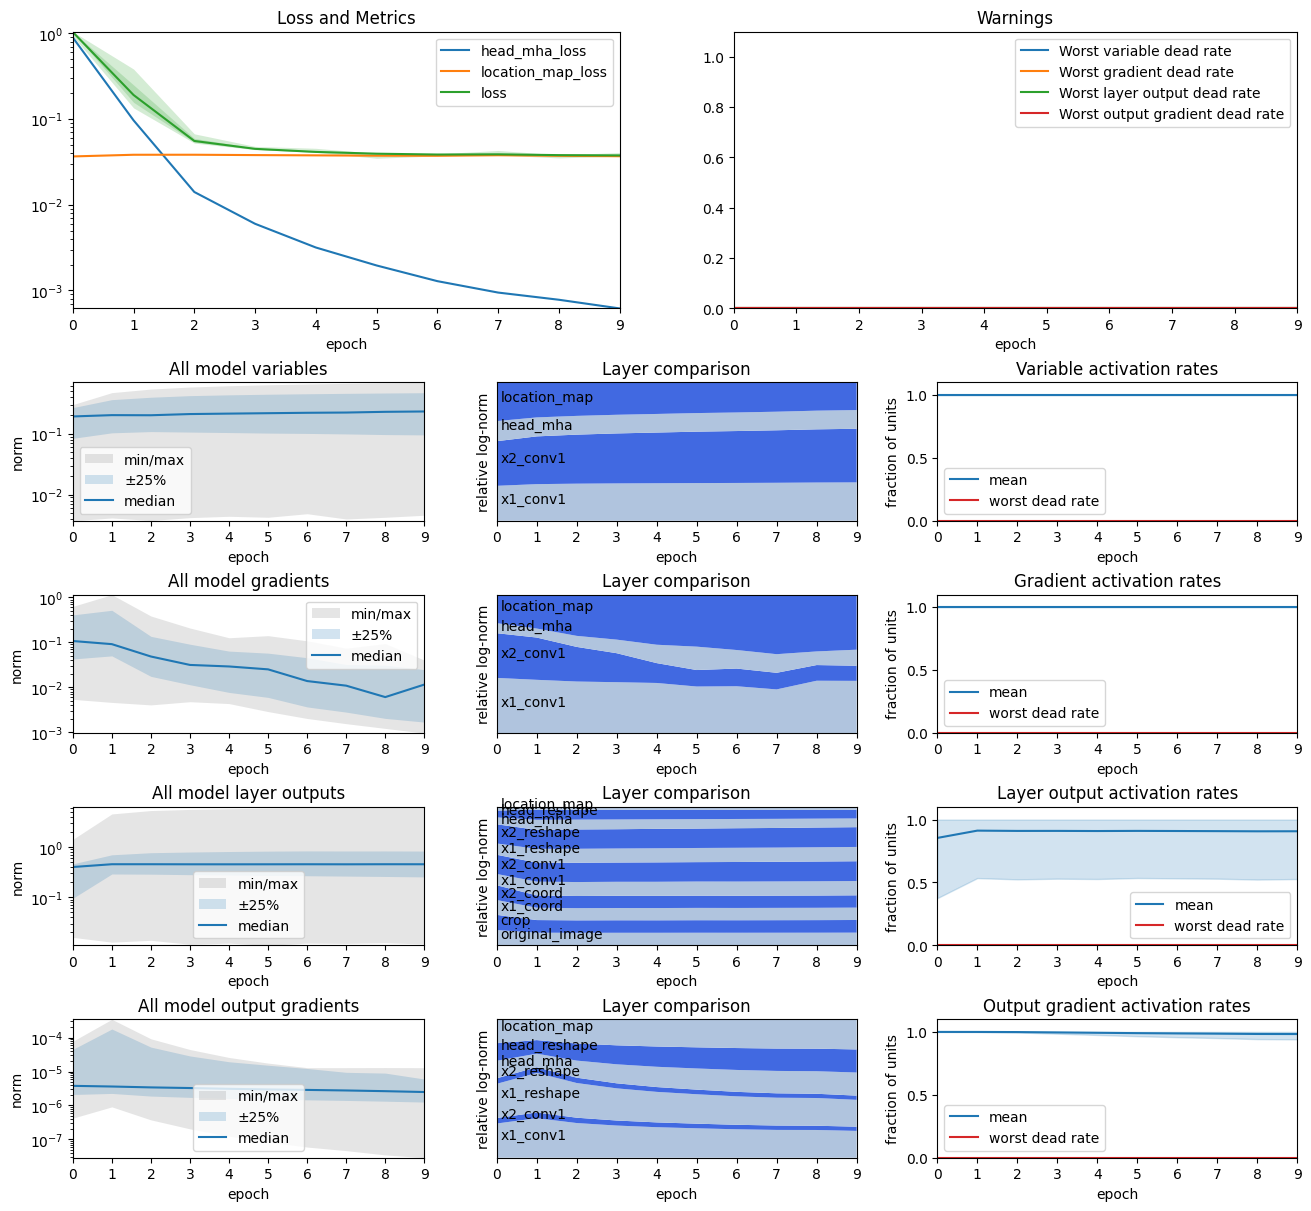

In [92]:
tinstr.plot_history_overview([history, variables, gradients, outputs, output_gradients])

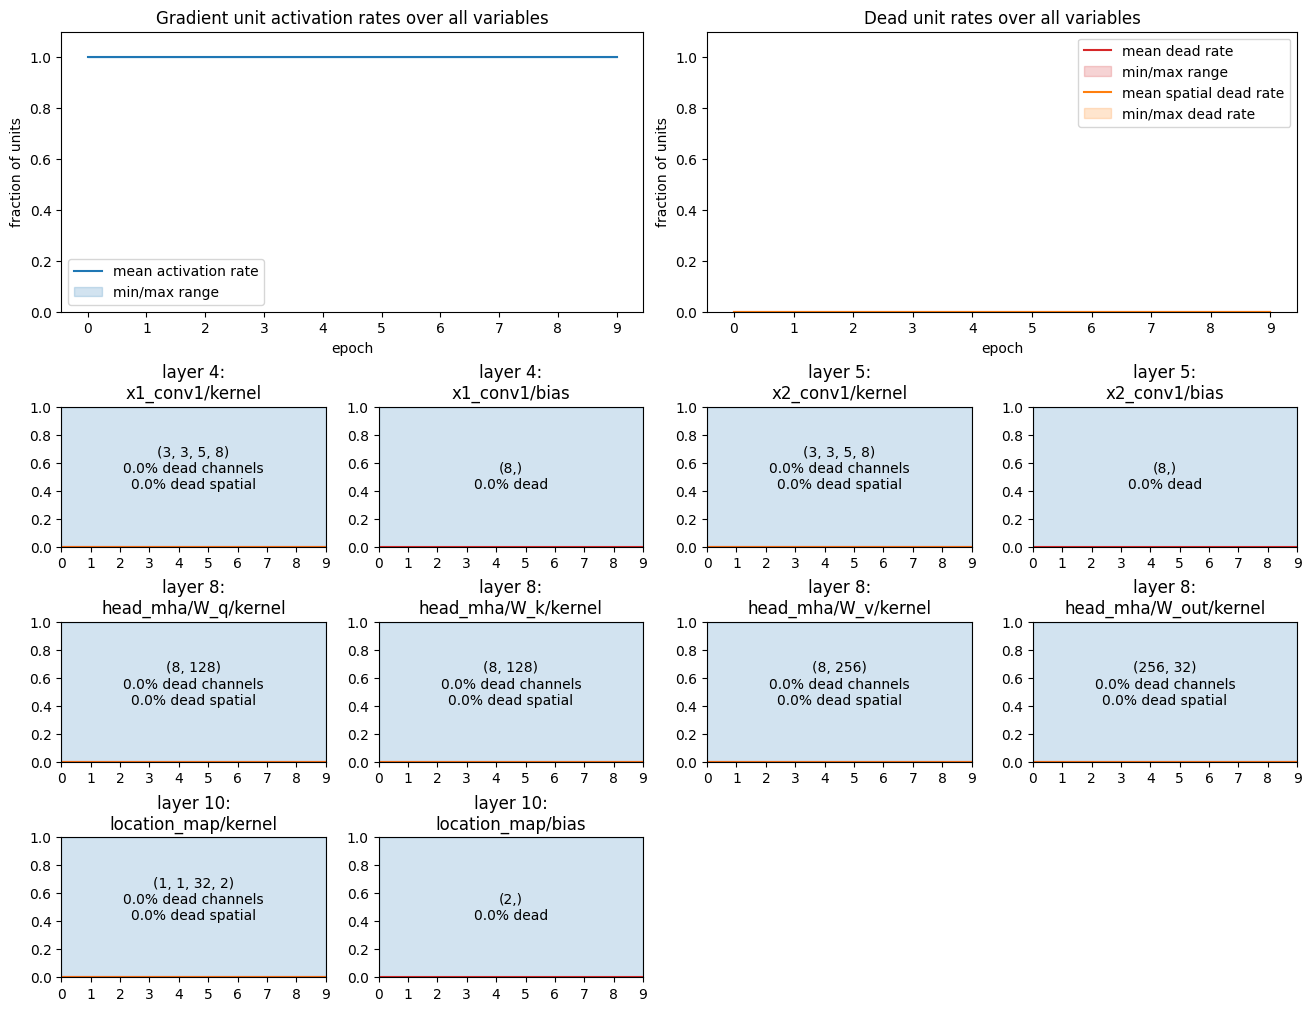

In [93]:
tinstr.plot_activity_history(gradients)

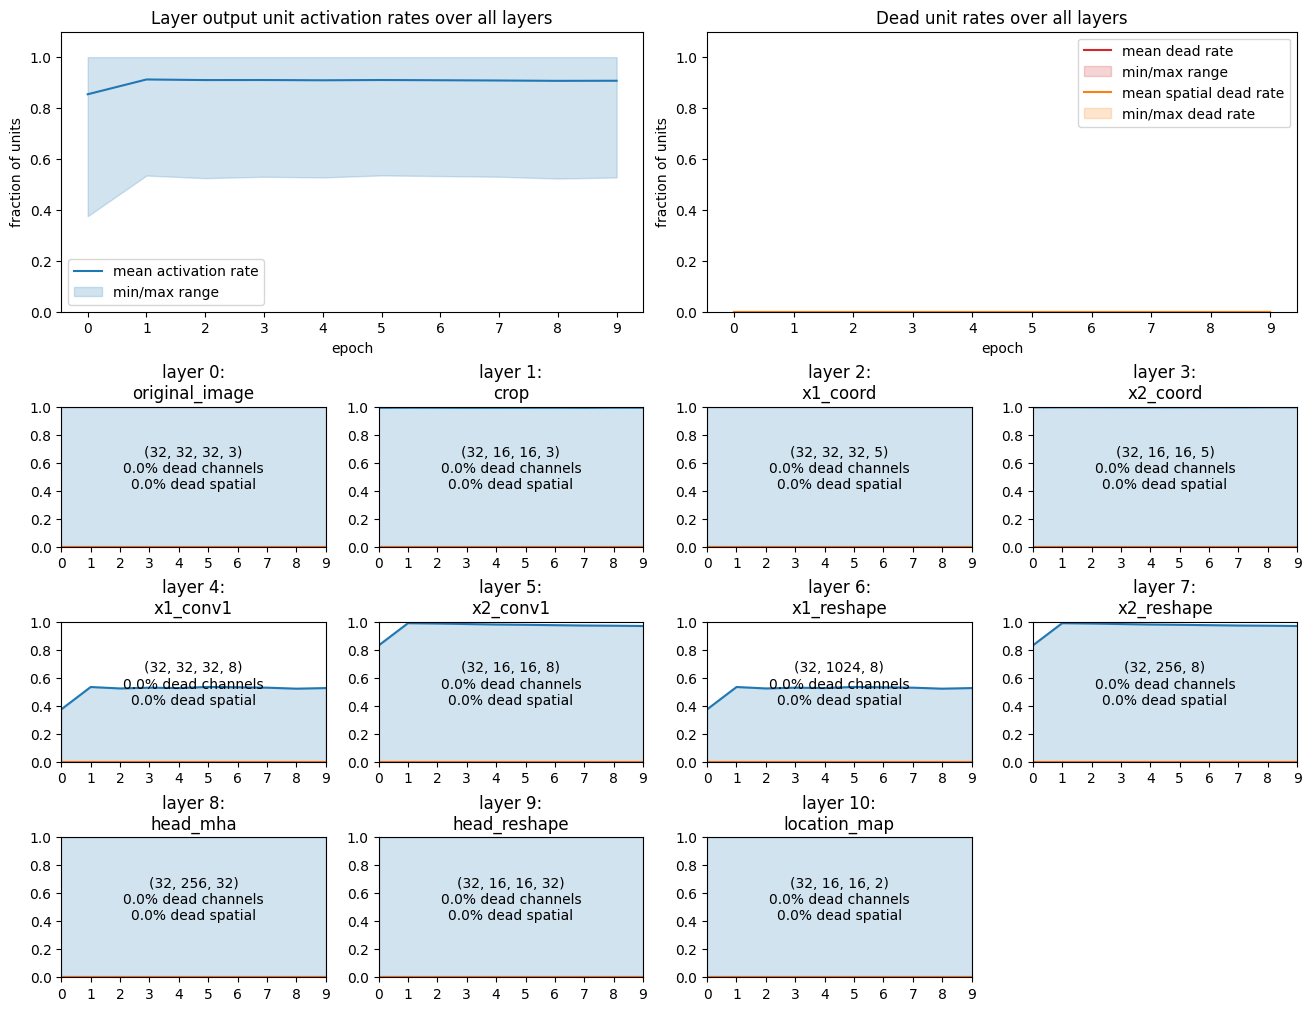

In [94]:
tinstr.plot_activity_history(outputs)

**Conclusions**

Neither BatchNormalization nor max attn_score regularization has prevented the reduction in neuron activity within the input layers. And neither has resulted in any improvement in training progress.

Ultimately I am even more convinced now that the attn_coefficients alone is a better keystone for the model architecture.

1. In considering what loss function to apply to the x_attn output, I initially started implementing a more accurate loss function that constructed an approximation of the specific decide x_attn tensor. ie: I was beginning to calculate from the location_map exactly which attn positions should be 1s and the rest zeros. Given that such a thing can be computed directly from the desired location_map, it becomes obvious that the attn coefficient matrix and the location_map are synonymous.

2. This makes me think that I could completely change everything. Don't output locations. Just output an attn matrix as a one-hot-encoded indication of original_image pixel (or anti-aliased pixels) that each cropped-pixel came from. Then apply binary CE loss.

2. By dropping the value output from the CrossAttention, and working directly with the attn coefficients, we have a much simpler model.

3. The only problem I believe I really face with the attn coefficients matrix is that some image pixels will be harder to match against discrete features than others. And that's where using a weighted approach will work when finally computing the global transform.

So, new model design:

* output = anti-aliased version of one-hot-encoded source pixel indication, shape: (batch_size, 256, 1024)
* note that the dataset should be fairly easy to setup.
* model arch:
  * bunch of conv layers for each of x1 and x2
  * feeds into MHA
  * attn as final output